In [1]:
# Importing DataLoaders for each model. These models include rule-based, vanilla DQN and encoder-decoder DQN.
from DataLoader.DataLoader import YahooFinanceDataLoader
from DataLoader.DataForPatternBasedAgent import DataForPatternBasedAgent
from DataLoader.DataAutoPatternExtractionAgent import DataAutoPatternExtractionAgent
from DataLoader.DataSequential import DataSequential

from DeepRLAgent.MLPEncoder.Train import Train as SimpleMLP
from DeepRLAgent.SimpleCNNEncoder.Train import Train as SimpleCNN
from EncoderDecoderAgent.GRU.Train import Train as GRU
from EncoderDecoderAgent.CNN.Train import Train as CNN
from EncoderDecoderAgent.CNN2D.Train import Train as CNN2d
from EncoderDecoderAgent.CNNAttn.Train import Train as CNN_ATTN
from EncoderDecoderAgent.CNN_GRU.Train import Train as CNN_GRU

# Imports for Deep RL Agent
from DeepRLAgent.VanillaInput.Train import Train as DeepRL

import pandas as pd
import torch
import os
import random
import numpy as np
from utils import save_pkl, load_pkl, set_random_seed, plot_hyperparams, plot_optimization_progress, plot_prob_accusition
import os
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

DATA_LOADERS = {
    'BTC-USD': YahooFinanceDataLoader(
        'BTC-USD',
        split_point='2021-01-01',
        validation_split_point='2023-01-01',
        load_from_file=True
    ),

    'GOOGL': YahooFinanceDataLoader(
        'GOOGL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    ),

    'AAPL': YahooFinanceDataLoader(
        'AAPL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        begin_date='2010-01-01',
        end_date='2020-08-24',
        load_from_file=True
    ),

    'DJI': YahooFinanceDataLoader(
        'DJI',
        split_point='2016-01-01',
        validation_split_point='2018-01-01',
        begin_date='2009-01-01',
        end_date='2018-09-30',
        load_from_file=True
    ),

    'S&P': YahooFinanceDataLoader(
        'S&P',
        split_point=2000,
        validation_split_point=2000,
        end_date='2018-09-25',
        load_from_file=True
    ),

    'AMD': YahooFinanceDataLoader(
        'AMD',
        split_point=2000,
        validation_split_point=2000,
        end_date='2018-09-25',
        load_from_file=True
    ),

    'GE': YahooFinanceDataLoader(
        'GE',
        split_point='2015-01-01',
        validation_split_point='2015-01-01',
        load_from_file=True
    ),

    'KSS': YahooFinanceDataLoader(
        'KSS',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    ),

    'HSI': YahooFinanceDataLoader(
        'HSI',
        split_point='2015-01-01',
        validation_split_point='2015-01-01',
        load_from_file=True
    ),

    'AAL': YahooFinanceDataLoader(
        'AAL',
        split_point='2018-01-01',
        validation_split_point='2018-01-01',
        load_from_file=True
    )
}


class SensitivityRun:
    def __init__(
        self,
            dataset_name,
            gamma,
            batch_size,
            replay_memory_size,
            feature_size,
            target_update,
            n_episodes,
            n_step,
            window_size,
            device,
            evaluation_parameter='gamma',
            transaction_cost=0):
        """

        @param data_loader:
        @param dataset_name:
        @param gamma:
        @param batch_size:
        @param replay_memory_size:
        @param feature_size:
        @param target_update:
        @param n_episodes:
        @param n_step:
        @param window_size:
        @param device:
        @param evaluation_parameter: shows which parameter are we evaluating and can be: 'gamma', 'batch size',
            or 'replay memory size'
        @param transaction_cost:
        """
        self.data_loader = DATA_LOADERS[dataset_name]
        self.test_data_first_price = self.data_loader.data_test_with_date.close[0]
        self.val_data_first_price = self.data_loader.data_validation_with_date.close[0]
        self.dataset_name = dataset_name
        self.gamma = gamma
        self.batch_size = batch_size
        self.replay_memory_size = replay_memory_size
        self.feature_size = feature_size
        self.target_update = target_update
        self.n_episodes = n_episodes
        self.n_step = n_step
        self.transaction_cost = transaction_cost
        self.window_size = window_size
        self.device = device
        self.evaluation_parameter = evaluation_parameter
        # The state mode is only for autoPatternExtractionAgent. Therefore, for pattern inputs, the state mode would be
        # set to None, because it can be recovered from the name of the data loader (e.g. dataTrain_patternBased).

        self.STATE_MODE_OHLC = 1
        self.STATE_MODE_CANDLE_REP = 4  # %body + %upper-shadow + %lower-shadow
        # window with k candles inside + the trend of those candles
        self.STATE_MODE_WINDOWED = 5

        self.dataTrain_autoPatternExtractionAgent = None
        self.dataTest_autoPatternExtractionAgent = None
        self.dataValidation_autoPatternExtractionAgent = None
        self.dataTrain_patternBased = None
        self.dataTest_patternBased = None
        self.dataValidation_patternBased = None
        self.dataTrain_autoPatternExtractionAgent_candle_rep = None
        self.dataTest_autoPatternExtractionAgent_candle_rep = None
        self.dataValidation_autoPatternExtractionAgent_candle_rep = None
        self.dataTrain_autoPatternExtractionAgent_windowed = None
        self.dataTest_autoPatternExtractionAgent_windowed = None
        self.dataValidation_autoPatternExtractionAgent_windowed = None
        self.dataTrain_sequential = None
        self.dataTest_sequential = None
        self.dataValidation_sequential = None
        self.model_in_question = None
        self.experiment_path = os.path.join(
            os.getcwd(), 'Results/' + self.evaluation_parameter + '/')
        if not os.path.exists(self.experiment_path):
            os.makedirs(self.experiment_path)

        self.models = {
            'DQN-pattern': None,
            'DQN-vanilla': None,
            'DQN-candlerep': None,
            'DQN-windowed': None,
            'MLP-pattern': None,
            'MLP-vanilla': None,
            'MLP-candlerep': None,
            'MLP-windowed': None,
            'CNN1d': None,
            'CNN2d': None,
            'GRU': None,
            'Deep-CNN': None,
            'CNN-GRU': None,
            'CNN-ATTN': None}

        self.test_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}

        self.train_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}

        self.validation_portfolios = {
            'DQN-pattern': {},
            'DQN-vanilla': {},
            'DQN-candlerep': {},
            'DQN-windowed': {},
            'MLP-pattern': {},
            'MLP-vanilla': {},
            'MLP-candlerep': {},
            'MLP-windowed': {},
            'CNN1d': {},
            'CNN2d': {},
            'GRU': {},
            'Deep-CNN': {},
            'CNN-GRU': {},
            'CNN-ATTN': {}}
        
        self.reset()

    def reset(self):
        self.load_data()
        self.load_agents()

    def load_data(self):
        self.dataTrain_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_OHLC,
                'action_auto_pattern_extraction',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_train,
                self.data_loader.patterns,
                'action_pattern',
                self.device, self.gamma,
                self.n_step, self.batch_size,
                self.transaction_cost)

        self.dataTest_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_test,
                self.data_loader.patterns,
                'action_pattern',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.transaction_cost)

        self.dataValidation_patternBased = \
            DataForPatternBasedAgent(
                self.data_loader.data_validation,
                self.data_loader.patterns,
                'action_pattern',
                self.device,
                self.gamma,
                self.n_step,
                self.batch_size,
                self.transaction_cost)

        self.dataTrain_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step, self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent_candle_rep = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_CANDLE_REP,
                'action_candle_rep',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_train,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTest_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_test,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataValidation_autoPatternExtractionAgent_windowed = \
            DataAutoPatternExtractionAgent(
                self.data_loader.data_validation,
                self.STATE_MODE_WINDOWED,
                'action_auto_extraction_windowed',
                self.device,
                self.gamma, self.n_step,
                self.batch_size,
                self.window_size,
                self.transaction_cost)

        self.dataTrain_sequential = DataSequential(
            self.data_loader.data_train,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

        self.dataTest_sequential = DataSequential(
            self.data_loader.data_test,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

        self.dataValidation_sequential = DataSequential(
            self.data_loader.data_validation,
            'action_sequential',
            self.device,
            self.gamma,
            self.n_step,
            self.batch_size,
            self.window_size,
            self.transaction_cost)

    def load_agents(self):
        self.models['DQN-pattern'] = DeepRL(
            self.data_loader,
            self.dataTrain_patternBased,
            self.dataTest_patternBased,
            self.dataValidation_patternBased,
            self.dataset_name,
            None,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-vanilla'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-candlerep'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_candle_rep,
            self.dataTest_autoPatternExtractionAgent_candle_rep,
            self.dataValidation_autoPatternExtractionAgent_candle_rep,
            self.dataset_name,
            self.STATE_MODE_CANDLE_REP,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['DQN-windowed'] = DeepRL(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_windowed,
            self.dataTest_autoPatternExtractionAgent_windowed,
            self.dataValidation_autoPatternExtractionAgent_windowed,
            self.dataset_name,
            self.STATE_MODE_WINDOWED,
            self.window_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-pattern'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_patternBased,
            self.dataTest_patternBased,
            self.dataValidation_patternBased,
            self.dataset_name,
            None,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-vanilla'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-candlerep'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_candle_rep,
            self.dataTest_autoPatternExtractionAgent_candle_rep,
            self.dataValidation_autoPatternExtractionAgent_candle_rep,
            self.dataset_name,
            self.STATE_MODE_CANDLE_REP,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['MLP-windowed'] = SimpleMLP(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent_windowed,
            self.dataTest_autoPatternExtractionAgent_windowed,
            self.dataValidation_autoPatternExtractionAgent_windowed,
            self.dataset_name,
            self.STATE_MODE_WINDOWED,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['CNN1d'] = SimpleCNN(
            self.data_loader,
            self.dataTrain_autoPatternExtractionAgent,
            self.dataTest_autoPatternExtractionAgent,
            self.dataValidation_autoPatternExtractionAgent,
            self.dataset_name,
            self.STATE_MODE_OHLC,
            self.window_size,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step)

        self.models['CNN2d'] = CNN2d(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.feature_size,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['GRU'] = GRU(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['Deep-CNN'] = CNN(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['CNN-GRU'] = CNN_GRU(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

        self.models['CNN-ATTN'] = CNN_ATTN(
            self.data_loader,
            self.dataTrain_sequential,
            self.dataTest_sequential,
            self.dataValidation_sequential,
            self.dataset_name,
            self.transaction_cost,
            self.feature_size,
            BATCH_SIZE=self.batch_size,
            GAMMA=self.gamma,
            ReplayMemorySize=self.replay_memory_size,
            TARGET_UPDATE=self.target_update,
            n_step=self.n_step,
            window_size=self.window_size)

    def train(self):
        self.models[self.model_in_question].train(self.n_episodes)

    def evaluate_sensitivity(self):
        key = None
        if self.evaluation_parameter == 'gamma':
            key = self.gamma
        elif self.evaluation_parameter == 'batch size':
            key = self.batch_size
        elif self.evaluation_parameter == 'replay memory size':
            key = self.replay_memory_size
        else:
            key = f'G: {self.gamma}, BS: {self.batch_size}, RMS: {self.replay_memory_size}, n: {self.n_step}, episodes: {self.n_episodes}'

        # Train
        self.train_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            test_type='train').get_daily_portfolio_value()

        # Test
        self.test_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            initial_investment=self.test_data_first_price).get_daily_portfolio_value()

        # Validation
        self.validation_portfolios[self.model_in_question][key] = self.models[self.model_in_question].test(
            test_type='validation', initial_investment=self.val_data_first_price).get_daily_portfolio_value()

    def average_return(self):
        key = None
        if self.evaluation_parameter == 'gamma':
            key = self.gamma
        elif self.evaluation_parameter == 'batch size':
            key = self.batch_size
        elif self.evaluation_parameter == 'replay memory size':
            key = self.replay_memory_size
        else:
            key = f'G: {self.gamma}, BS: {self.batch_size}, RMS: {self.replay_memory_size}, n: {self.n_step}, episodes: {self.n_episodes}'

        self.avg_returns = (self.test_portfolios[self.model_in_question][key][-1] - self.test_portfolios[self.model_in_question][key][0]) \
            / self.test_portfolios[self.model_in_question][key][0] * 100
        return self.avg_returns

    def plot_and_save_sensitivity(self, data_set='test'):
        data = None
        if data_set == 'train':
            data = self.train_portfolios
        elif data_set == 'validation':
            data = self.validation_portfolios
        else:
            data = self.test_portfolios

        portfolio_plot_path = os.path.join(
            self.experiment_path, f'plots/portfolio/on_{data_set}')
        if not os.path.exists(portfolio_plot_path):
            os.makedirs(portfolio_plot_path)

        fig = make_subplots(specs=[[{"secondary_y": True}]])
        for gamma, color in zip(data[self.model_in_question], px.colors.qualitative.Plotly):

            profit_percentage = [
                (data[self.model_in_question][gamma][i] - data[self.model_in_question][gamma][0]) /
                data[self.model_in_question][gamma][0] * 100
                for i in range(len(data[self.model_in_question][gamma]))]

            if data_set == 'test':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_test_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_test_with_date.index,
                                                'portfolio': profit_percentage[difference:]})
            elif data_set == 'train':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_train_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_train_with_date.index,
                                                'portfolio': profit_percentage[difference:]})

            elif data_set == 'validation':
                difference = len(data[self.model_in_question][gamma]) - \
                    len(self.data_loader.data_validation_with_date)
                prediction_df = pd.DataFrame({'date': self.data_loader.data_validation_with_date.index,
                                                'portfolio': profit_percentage[difference:]})

            # Add a trace for each line
            fig.add_trace(go.Scatter(x=prediction_df['date'], y=prediction_df['portfolio'],
                                        mode='lines', name=gamma, line=dict(color=color)), secondary_y=False)

        # Update plot layout
        fig.update_layout(title=f'Tuning Hyperparameters of {self.model_in_question} using {self.evaluation_parameter} on {data_set} data',
                            xaxis_title='Time',
                            yaxis_title='% Rate of Return',
                            legend_title="Hyper-parameters",
                            font=dict(size=10))

        # Save plot as an file
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.html')
        fig.write_html(fig_file)
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.pdf')
        fig.write_image(fig_file)
        fig_file = os.path.join(portfolio_plot_path, f'{self.model_in_question}.svg')
        fig.write_image(fig_file)

    def plot_and_save_return(self):
        prediction_plot_path = os.path.join(
            self.experiment_path, 'plots/prediction')
        if not os.path.exists(prediction_plot_path):
            os.makedirs(prediction_plot_path)

        fig = go.Figure()
        colors = px.colors.qualitative.Plotly

        # Train data
        train_df = pd.DataFrame(
            self.data_loader.data_train_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=train_df.index,
                        y=train_df['close'], mode='lines', name='Train', line=dict(color=colors[0])))

        # Test data
        test_df = pd.Series(
            self.data_loader.data_test_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=test_df.index, y=test_df,
                        mode='lines', name='Test', line=dict(color=colors[1])))

        # Validation data
        validation_df = pd.Series(
            self.data_loader.data_validation_with_date.close, index=self.data_loader.data.index)
        fig.add_trace(go.Scatter(x=validation_df.index, y=validation_df,
                        mode='lines', name='Validation', line=dict(color=colors[2])))

        # Predictions
        for gamma, color in zip(self.test_portfolios[self.model_in_question], colors[3:]):
            difference = len(
                self.test_portfolios[self.model_in_question][gamma]) - len(self.data_loader.data_test_with_date)
            prediction_series = pd.Series(self.test_portfolios[self.model_in_question][gamma][difference:],
                                            index=self.data_loader.data_test_with_date.index)
            prediction_series = prediction_series.reindex(
                self.data_loader.data.index, fill_value=np.nan)
            fig.add_trace(go.Scatter(x=prediction_series.index, y=prediction_series,
                            mode='lines', name=gamma, line=dict(color=color)))

        # Update plot layout
        fig.update_layout(title=f'Train, Test and Prediction of model {self.model_in_question} on dataset {self.dataset_name}',
                            xaxis_title='Time',
                            yaxis_title='Close Price',
                            legend_title="Legend",
                            font=dict(size=10))

        # Save plot
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.html')
        fig.write_html(fig_file)
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.pdf')
        fig.write_image(fig_file)
        fig_file = os.path.join(prediction_plot_path, f'{self.model_in_question}.svg')
        fig.write_image(fig_file) 

    def save_portfolios(self):
        path = os.path.join(self.experiment_path, 'test_portfolios.pkl')
        save_pkl(path, self.test_portfolios)
        path = os.path.join(self.experiment_path, 'tain_portfolios.pkl')
        save_pkl(path, self.train_portfolios)
        path = os.path.join(self.experiment_path, 'validation_portfolios.pkl')
        save_pkl(path, self.validation_portfolios)

    def save_experiment(self):
        self.plot_and_save_sensitivity(data_set='validation')
        self.plot_and_save_sensitivity(data_set='test')
        self.plot_and_save_sensitivity(data_set='train')
        self.plot_and_save_return()
        self.save_portfolios()


iter = 10
init_set = 2

models = [
    'DQN-pattern']
    # 'DQN-vanilla',
    # 'DQN-candlerep',
    # 'DQN-windowed',
    # 'MLP-pattern',
    # 'MLP-vanilla',
    # 'MLP-candlerep',
    # 'MLP-windowed',
    # 'CNN1d',
    # 'CNN2d',
    # 'GRU',
    # 'Deep-CNN',
    # 'CNN-GRU',
    # 'CNN-ATTN']

params = ['Gamma', 'Batch Size', 'Reply Memory Size', 'Number of Steps', 'Number of Episodes']
# gamma, log2(batch_size), log2(replay_memory_size), log2(n_step), n_episodes / 10
bounds = torch.tensor([[0.4, 8.0, 8.0, 2.0, 10.0], [1.0, 512.0, 512.0, 64.0, 60.0]])
types = [torch.float64, torch.int64, torch.int64, torch.int64, torch.int64]

n_step = 8
window_size = 3
dataset_name = "BTC-USD"
n_episodes = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on:', device)
feature_size = 64
target_update = 5

gamma_default = 0.9
batch_size_default = 16
replay_memory_size_default = 32

Running on: cpu


In [2]:
# Imports Optimizer
from Optimizer.SimpleBayesianOptimizer import SimpleBayesianOptimizer
set_random_seed(42)

In [3]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Simple BO (UCB)',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = SimpleBayesianOptimizer(objective_func, bounds, types, name='Simple BO (UCB)')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:12<00:00,  1.75it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [03:54<00:00,  8.07s/it]


Complete
tensor([1.])


0it [00:00, ?it/s]

tensor([  0.9592, 285.6197, 213.8878,  27.2392,  35.6410])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [00:23<00:00,  1.51it/s]


Complete


1it [00:28, 28.11s/it]

tensor([  0.6318, 234.4126, 404.9290,   9.0898,  46.9456])
Training DeepRL ...



100%|███████████████████████████████████████████| 47/47 [09:14<00:00, 11.79s/it]


Complete


2it [09:44, 339.08s/it]

tensor([  0.4507, 429.1635, 315.6887,  37.8638,  48.1609])
Training DeepRL ...



100%|███████████████████████████████████████████| 48/48 [00:29<00:00,  1.61it/s]


Complete


3it [10:18, 199.61s/it]

tensor([  0.6733, 209.9233, 191.2195,  61.5357,  52.9126])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [00:36<00:00,  1.47it/s]


Complete


4it [10:59, 136.87s/it]

tensor([  0.8211, 384.4858,   9.7312,  29.6794,  56.8717])
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [00:38<00:00,  1.47it/s]


Complete


5it [11:40, 102.56s/it]

tensor([  0.8021, 110.2748, 390.0908,  11.7741,  43.2542])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [06:33<00:00,  9.15s/it]


Complete


6it [18:17, 202.49s/it]

tensor([  0.6115, 330.3925,  34.4727,  53.5091,  26.9017])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:28<00:00,  1.07s/it]


Complete


7it [18:50, 147.05s/it]

tensor([  0.4290, 228.6429,  11.4178,  33.9626,  21.4889])
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [00:22<00:00,  1.06s/it]


Complete


8it [19:16, 108.68s/it]

tensor([  0.8765, 232.1135,  53.7737,   2.4407,  25.2856])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [00:27<00:00,  1.10s/it]


Complete


9it [19:48, 84.64s/it] 

tensor([  0.4295,  90.3806, 327.2780,  35.2159,  31.7542])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [07:10<00:00, 13.46s/it]


Complete


10it [27:04, 162.40s/it]


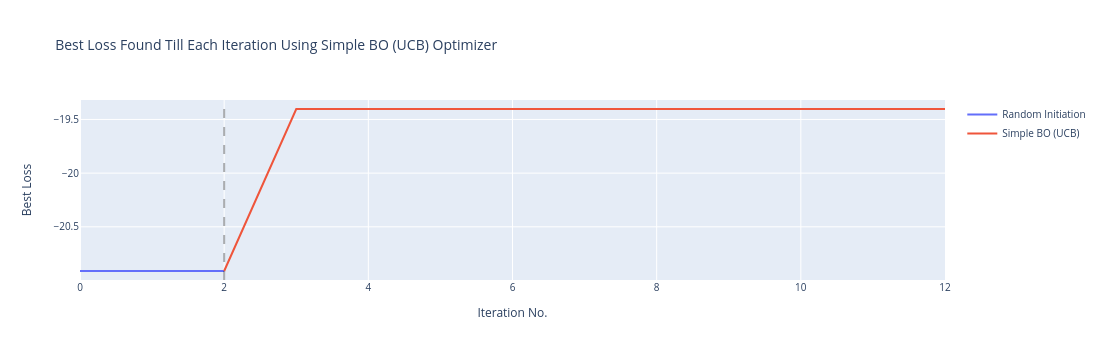

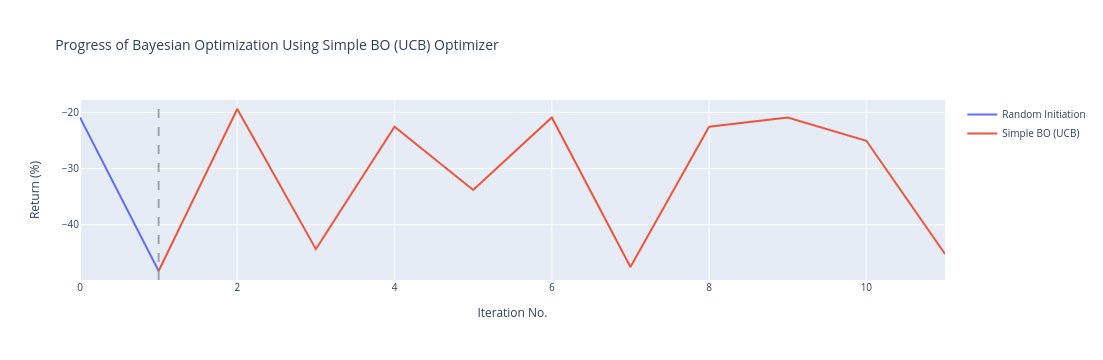

In [4]:
plot_optimization_progress(optimizer, init_set)

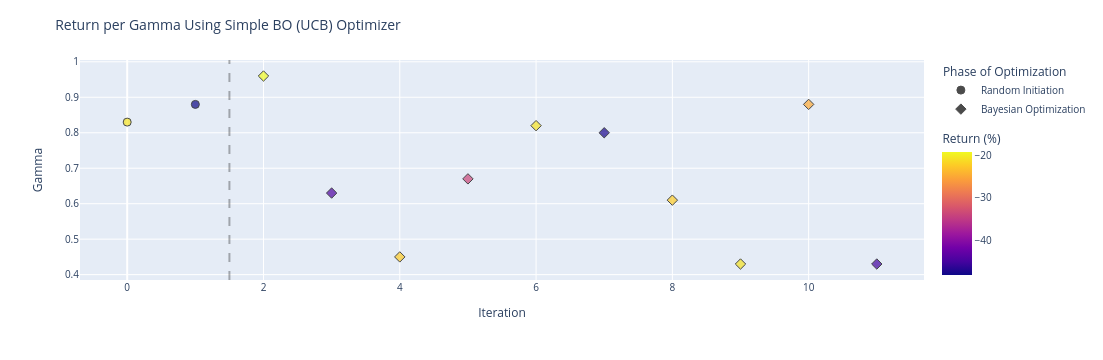

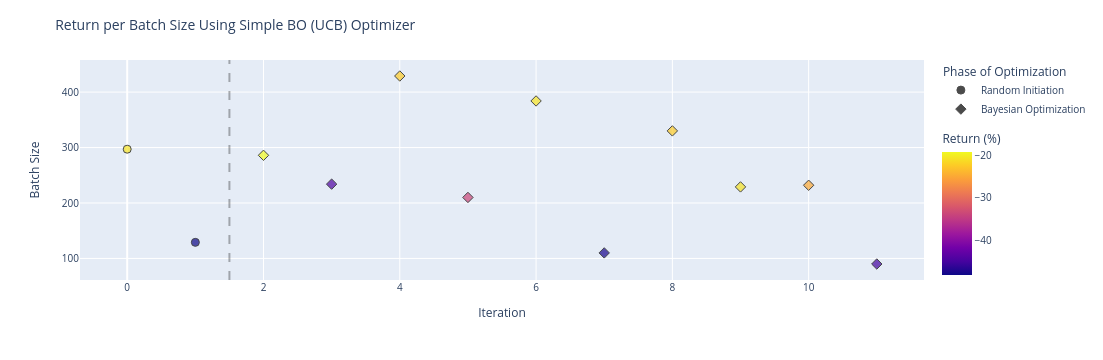

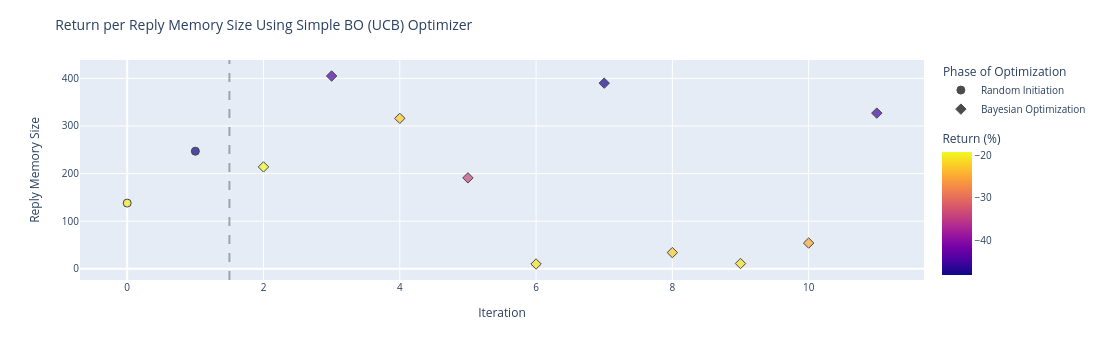

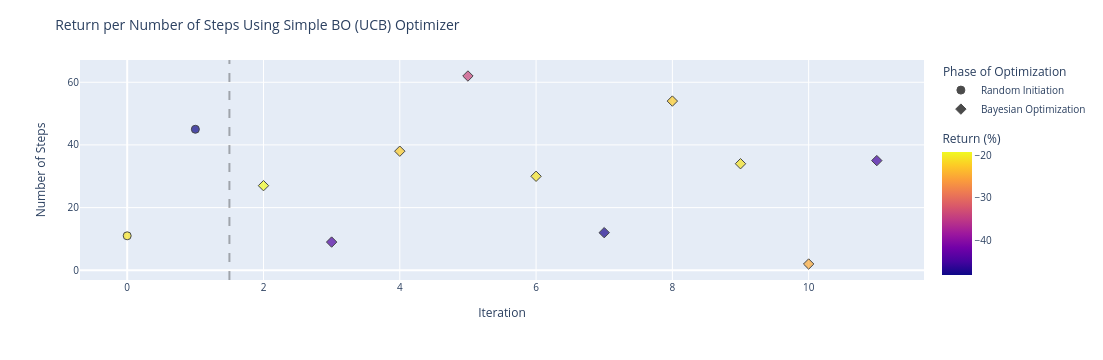

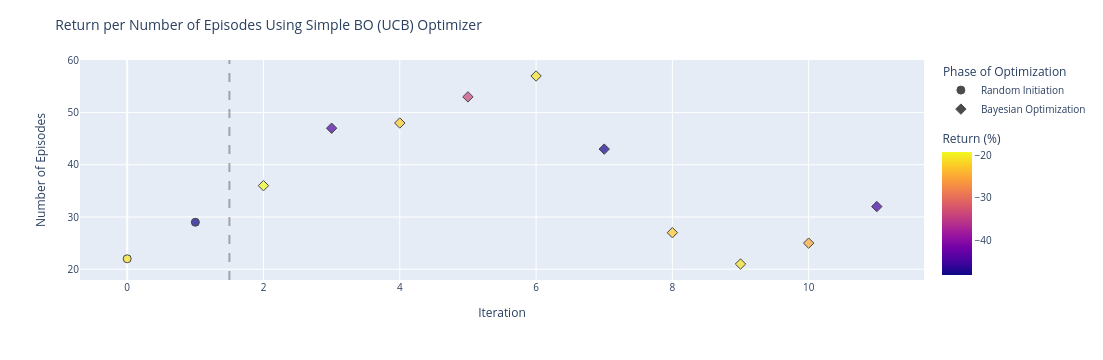

In [5]:
plot_hyperparams(params, optimizer, init_set)

In [6]:
# Imports Optimizer
from Optimizer.SimpleBayesianOptimizer import SimpleBayesianOptimizer
set_random_seed(42)

In [7]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Simple BO (EI)',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    # optimizer = load_pkl('run/Simple BO/DQN-pattern/optimizer.pkl')

    optimizer = SimpleBayesianOptimizer(objective_func, bounds, types, name='Simple BO (EI)')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set, acquisition_func='EI')

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:24<00:00,  1.12s/it]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [07:26<00:00, 15.41s/it]


Complete
tensor([1.])


0it [00:00, ?it/s]

tensor([ 0.7840, 13.3564, 45.6975, 38.6186, 32.9980])
Training DeepRL ...



100%|███████████████████████████████████████████| 33/33 [06:22<00:00, 11.60s/it]


Complete


1it [06:29, 389.35s/it]

tensor([  0.8514, 392.8185, 307.8506,  12.8016,  16.7361])
Training DeepRL ...



100%|███████████████████████████████████████████| 17/17 [00:20<00:00,  1.19s/it]


Complete


2it [06:56, 176.03s/it]

tensor([ 0.4267, 83.3531, 34.1628, 42.1090, 42.2693])
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [00:50<00:00,  1.20s/it]


Complete


3it [07:52, 121.21s/it]

tensor([  0.5865, 496.8116,  88.2659,   4.3382,  24.0321])
Training DeepRL ...



100%|███████████████████████████████████████████| 24/24 [00:31<00:00,  1.32s/it]


Complete


4it [08:28, 87.90s/it] 

tensor([  0.7840, 436.1129, 368.4278,  11.1273,  18.8539])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [00:23<00:00,  1.21s/it]


Complete


5it [08:58, 67.05s/it]

tensor([  0.6069,   9.7410, 379.5429,  33.5197,  31.6218])
Training DeepRL ...



100%|███████████████████████████████████████████| 32/32 [06:06<00:00, 11.45s/it]


Complete


6it [15:10, 170.74s/it]

tensor([  0.8557, 112.9181, 176.6842,  53.2639,  44.6137])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [10:39<00:00, 14.21s/it]


Complete


7it [25:55, 325.72s/it]

tensor([  0.6895,  14.5506, 388.9173,  25.2850,  22.6973])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [04:07<00:00, 10.76s/it]


Complete


8it [30:08, 302.51s/it]

tensor([  0.4784,  16.6583, 165.4266,   6.2359,  19.4230])
Training DeepRL ...



100%|███████████████████████████████████████████| 19/19 [03:34<00:00, 11.27s/it]


Complete


9it [33:46, 276.22s/it]

tensor([  0.7389, 284.0543, 379.9583,  15.2824,  11.0293])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [03:21<00:00, 18.28s/it]


Complete


10it [37:11, 223.16s/it]


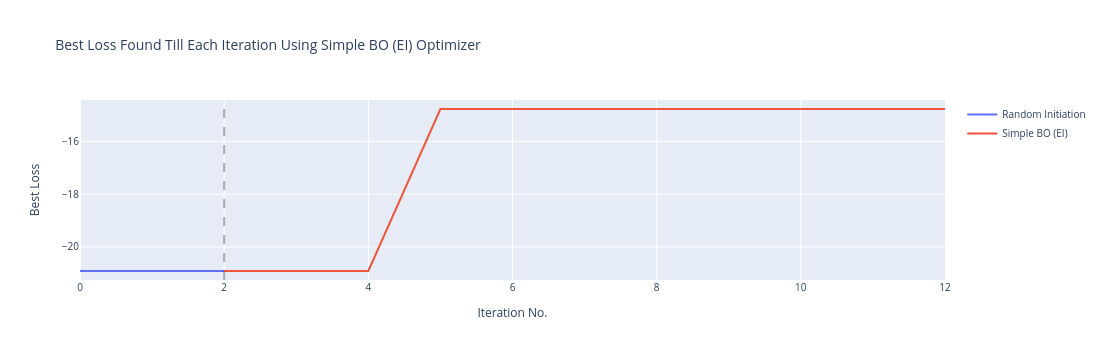

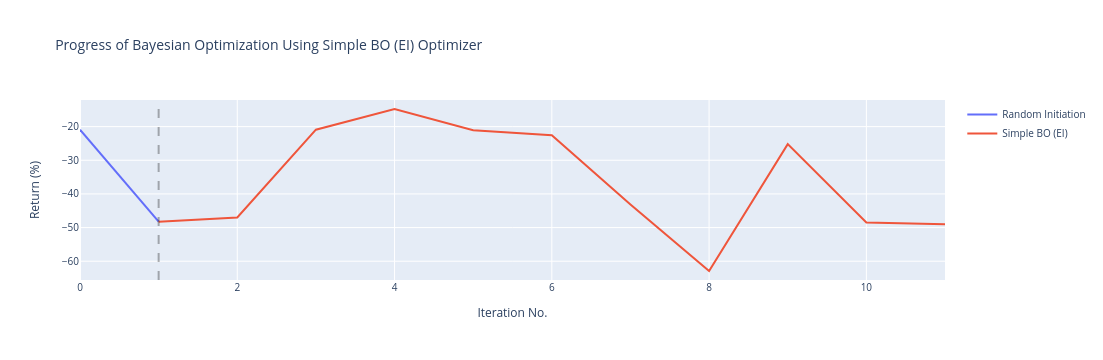

In [8]:
plot_optimization_progress(optimizer, init_set)

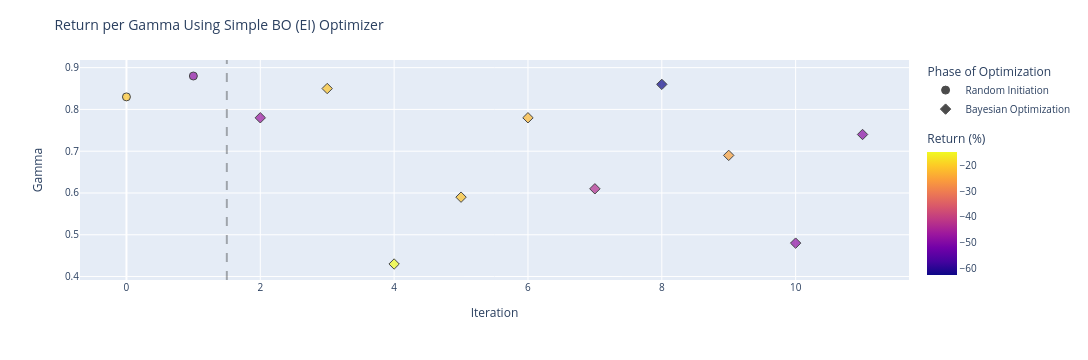

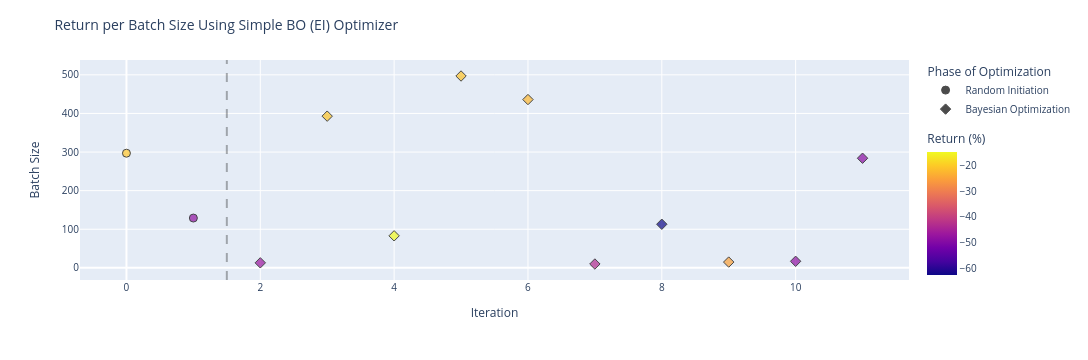

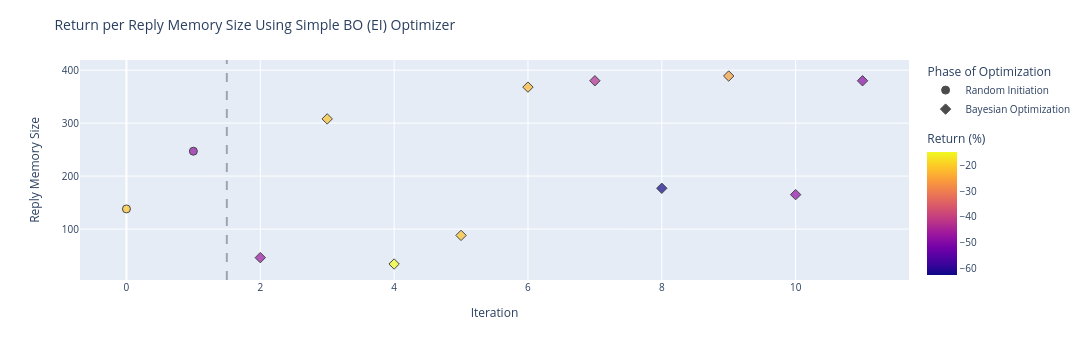

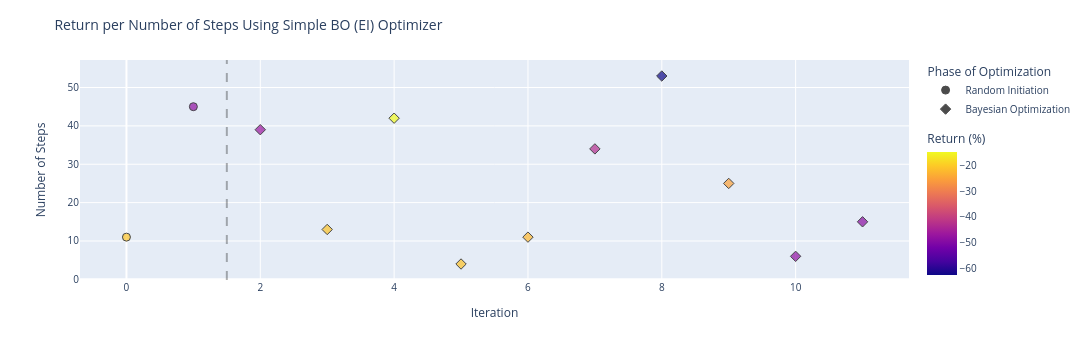

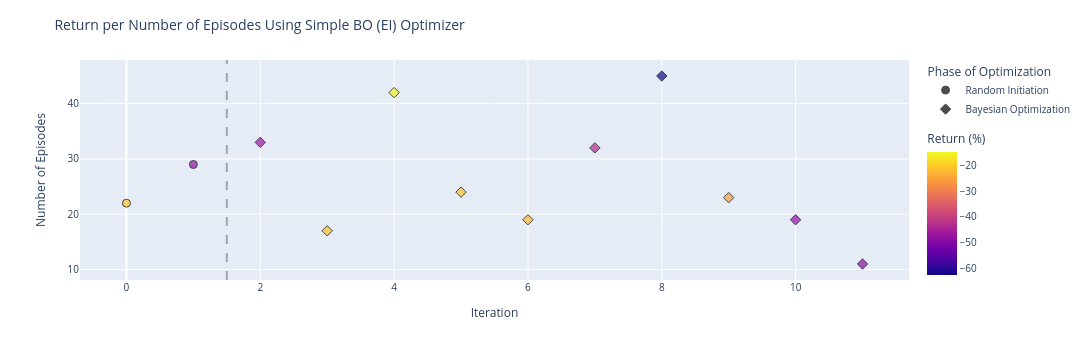

In [9]:
plot_hyperparams(params, optimizer, init_set)

In [10]:
# Imports Optimizer
from Optimizer.SimpleBayesianOptimizer import SimpleBayesianOptimizer
set_random_seed(42)

In [11]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Simple BO (PI)',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    # optimizer = load_pkl('run/Simple BO/DQN-pattern/optimizer.pkl')

    optimizer = SimpleBayesianOptimizer(objective_func, bounds, types, name='Simple BO (PI)')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set, acquisition_func='PI')

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:14<00:00,  1.51it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [05:13<00:00, 10.80s/it]


Complete
tensor([1.])


0it [00:00, ?it/s]

tensor([  0.4859, 441.0923, 361.3653,   3.5809,  19.7976])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


Complete


1it [00:19, 19.53s/it]

tensor([  0.5854, 481.2308,  72.6835,  54.5391,  31.3489])
Training DeepRL ...



100%|███████████████████████████████████████████| 31/31 [00:21<00:00,  1.46it/s]


Complete


2it [00:43, 22.15s/it]

tensor([  0.5013,  42.1641, 263.6518,  13.5348,  28.5244])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [03:02<00:00,  6.29s/it]


Complete


3it [03:48, 96.45s/it]

tensor([  0.7317, 113.2391, 444.7227,  62.5625,  15.3683])
Training DeepRL ...



100%|███████████████████████████████████████████| 15/15 [01:48<00:00,  7.22s/it]


Complete


4it [05:39, 102.09s/it]

tensor([  0.9681, 310.3902, 223.6654,   2.5960,  49.0012])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:23<00:00,  2.09it/s]


Complete


5it [06:04, 74.54s/it] 

tensor([  0.7472, 128.5174, 412.4156,   5.1503,  16.1927])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [01:48<00:00,  6.79s/it]


Complete


6it [07:55, 86.95s/it]

tensor([  0.7483,  77.1397, 475.8659,  19.2648,  42.3737])
Training DeepRL ...



100%|███████████████████████████████████████████| 42/42 [05:54<00:00,  8.45s/it]


Complete


7it [13:55, 176.20s/it]

tensor([4.5753e-01, 1.8692e+02, 5.0805e+02, 8.5228e+00, 4.3413e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [10:31<00:00, 14.68s/it]


Complete


8it [24:32, 322.76s/it]

tensor([  0.7180, 147.8556, 427.9512,  24.7149,  37.6840])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [08:12<00:00, 12.97s/it]


Complete


9it [32:49, 377.39s/it]

tensor([  0.6892,  36.0930, 383.2501,  55.8779,  51.6985])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [08:18<00:00,  9.58s/it]


Complete


10it [41:14, 247.45s/it]


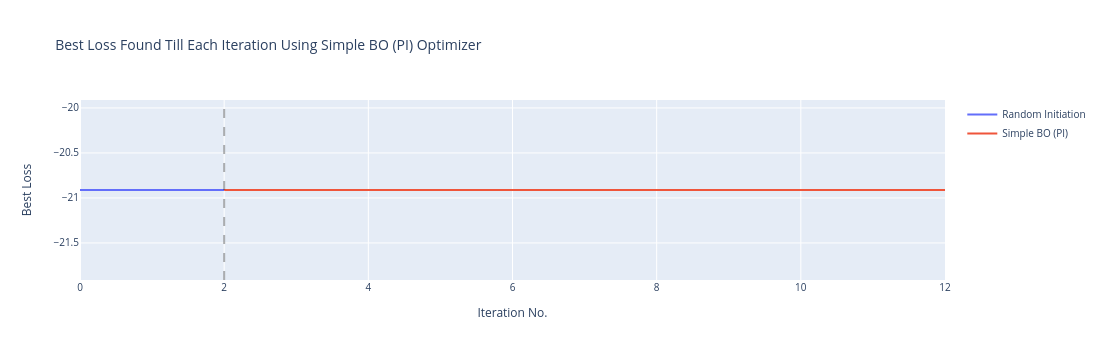

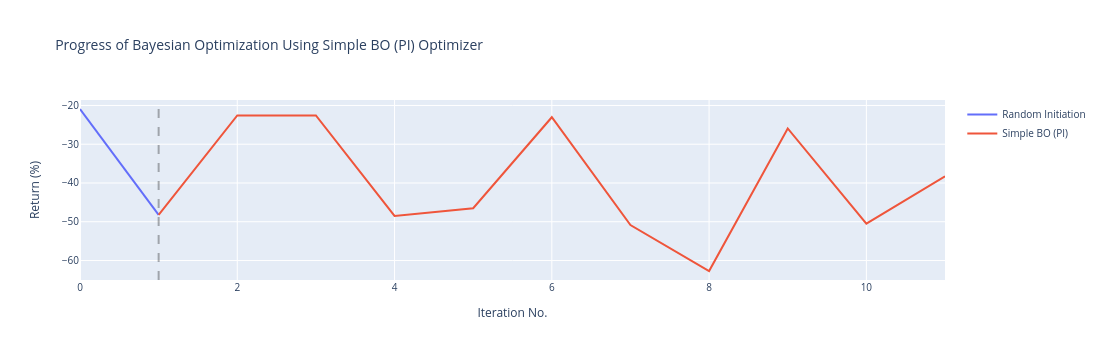

In [12]:
plot_optimization_progress(optimizer, init_set)

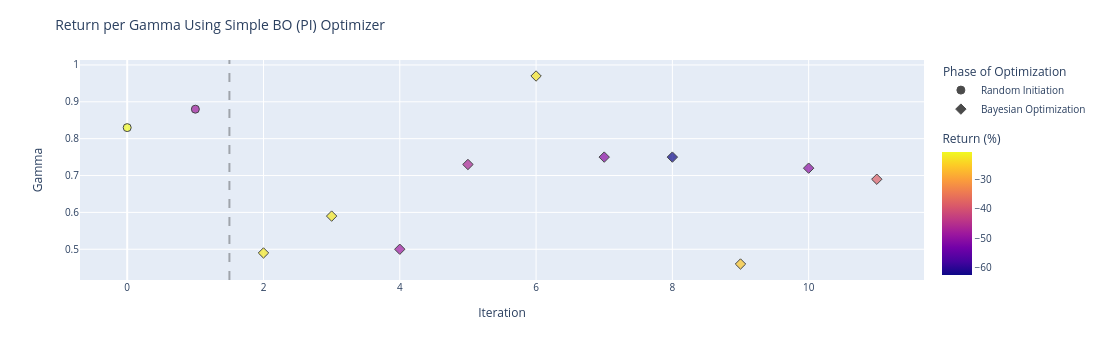

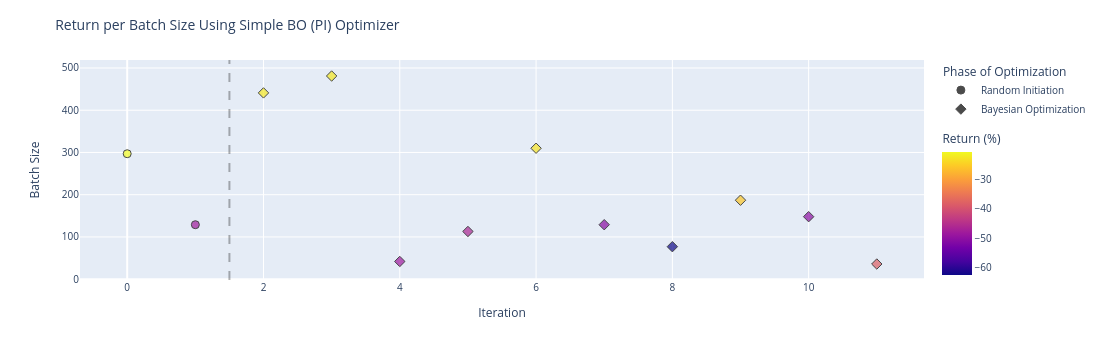

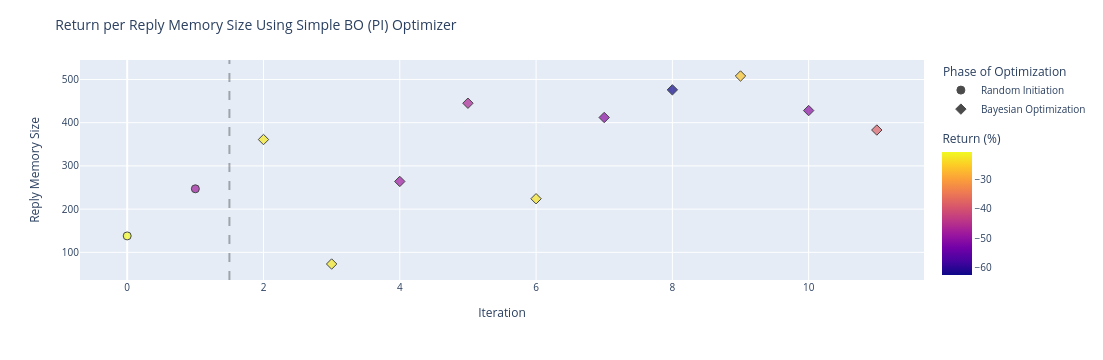

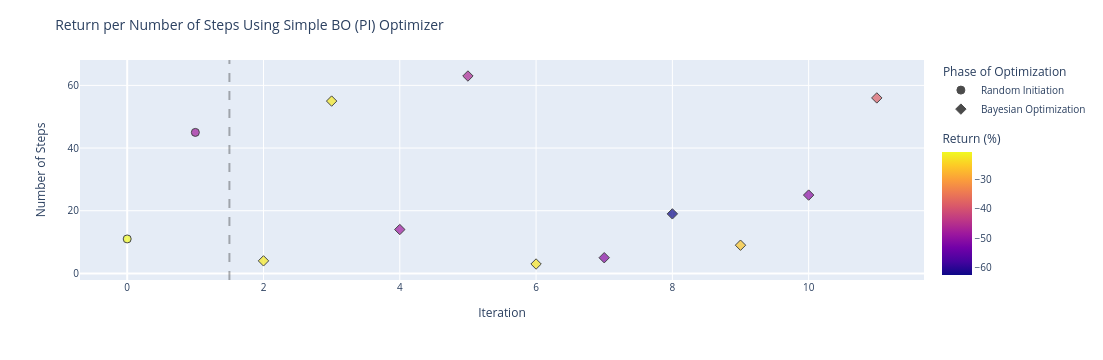

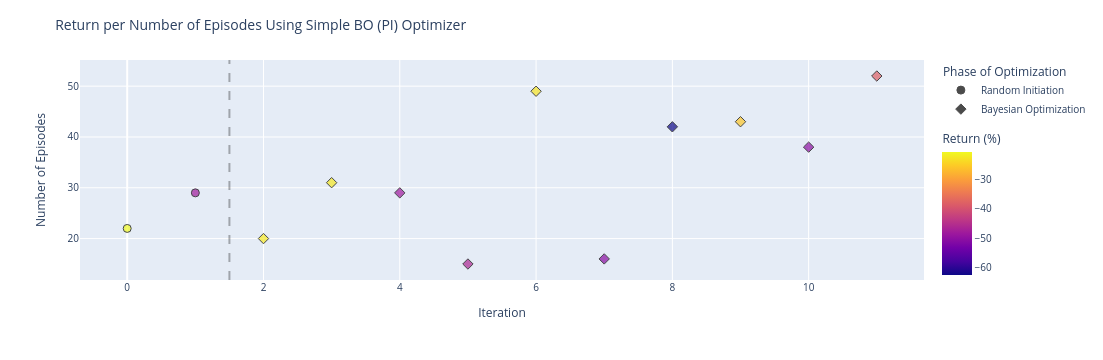

In [13]:
plot_hyperparams(params, optimizer, init_set)

In [14]:
# Imports Optimizer
from Optimizer.RandomSampling import RandomSearch
set_random_seed(42)

In [15]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='Random Search',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = RandomSearch(objective_func, bounds, types, name='Random Search')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:19<00:00,  1.14it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [05:56<00:00, 12.28s/it]


Complete


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor([4.3798e-01, 1.0600e+02, 4.7500e+02, 3.9000e+01, 5.2000e+01],
       dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [09:38<00:00, 11.12s/it]


Complete


 10%|████                                     | 1/10 [09:41<1:27:11, 581.26s/it]

tensor([  0.6382,  85.0000, 375.0000,   6.0000,  21.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 21/21 [02:26<00:00,  6.96s/it]


Complete


 30%|████████████▉                              | 3/10 [12:09<23:59, 205.71s/it]

tensor([  0.8518, 326.0000, 381.0000,  54.0000,  59.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [09:27<00:00,  9.62s/it]


Complete


 50%|█████████████████████▌                     | 5/10 [21:39<20:32, 246.49s/it]

tensor([  0.5915, 177.0000, 490.0000,  56.0000,  23.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [02:47<00:00,  7.27s/it]


Complete


 60%|█████████████████████████▊                 | 6/10 [24:29<15:03, 225.87s/it]

tensor([  0.9201, 110.0000,  76.0000,   5.0000,  12.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 12/12 [00:05<00:00,  2.23it/s]


Complete


 80%|██████████████████████████████████▍        | 8/10 [24:37<04:18, 129.44s/it]

tensor([  0.4128,  60.0000, 166.0000,  29.0000,  25.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [02:18<00:00,  5.55s/it]


Complete


 90%|██████████████████████████████████████▋    | 9/10 [26:58<02:12, 132.26s/it]

tensor([  0.6604,  44.0000, 500.0000,  20.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [01:08<00:00,  5.29s/it]


Complete


100%|██████████████████████████████████████████| 10/10 [28:09<00:00, 116.76s/it]

tensor([  0.9059, 329.0000, 431.0000,  53.0000,  52.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [08:27<00:00,  9.75s/it]


Complete


12it [36:38, 174.59s/it]                                                        

tensor([  0.9801, 501.0000, 370.0000,  32.0000,  13.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 13/13 [00:06<00:00,  2.00it/s]


Complete


13it [36:47, 136.36s/it]

tensor([  0.9966, 418.0000, 424.0000,  48.0000,  46.0000], dtype=torch.float64)
Training DeepRL ...



100%|███████████████████████████████████████████| 46/46 [08:57<00:00, 11.69s/it]


Complete


100%|██████████████████████████████████████████| 10/10 [45:47<00:00, 274.75s/it]


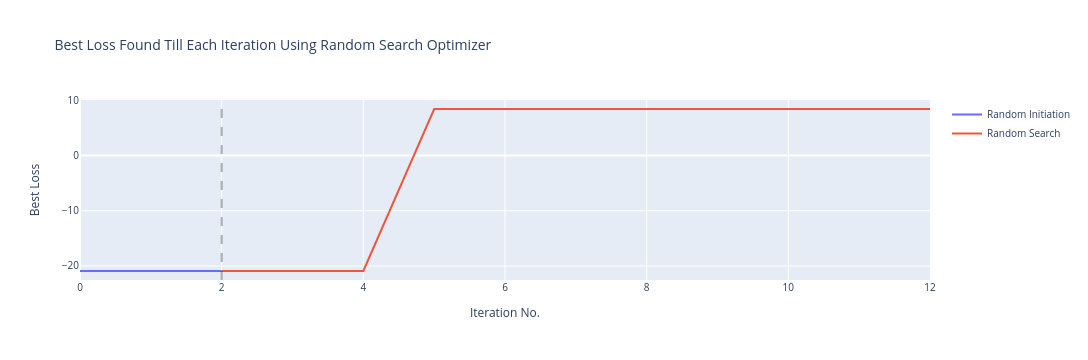

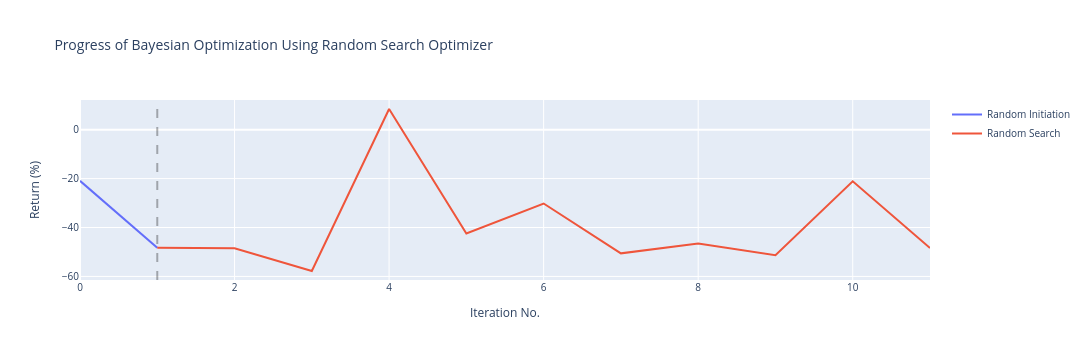

In [16]:
plot_optimization_progress(optimizer, init_set)

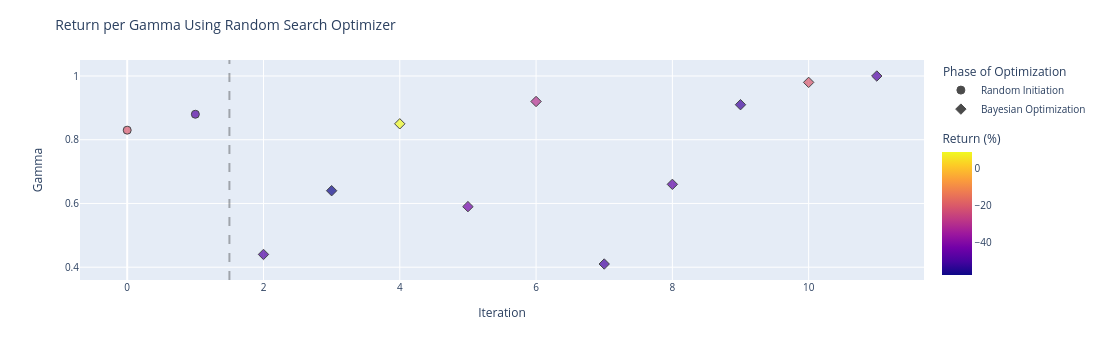

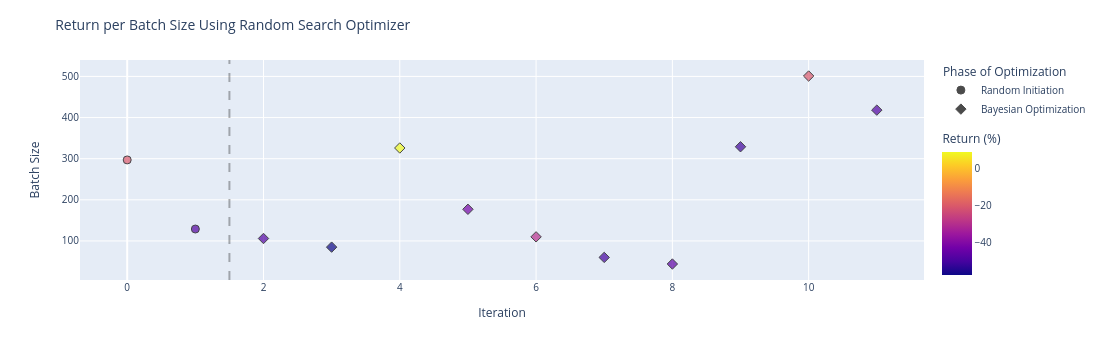

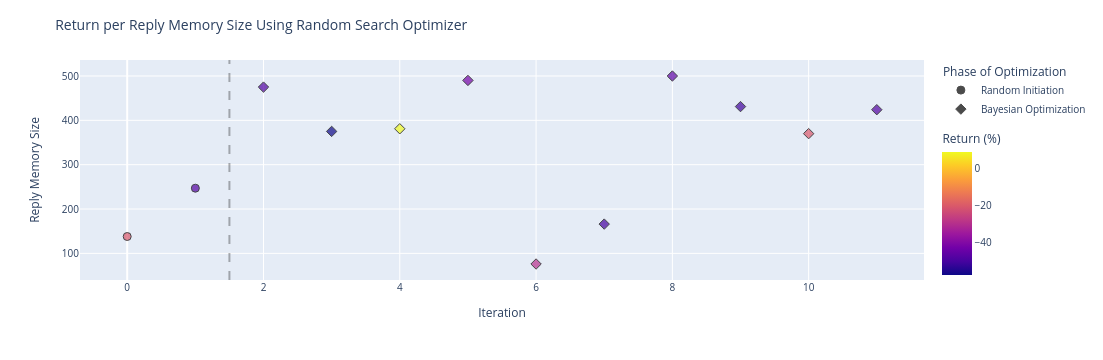

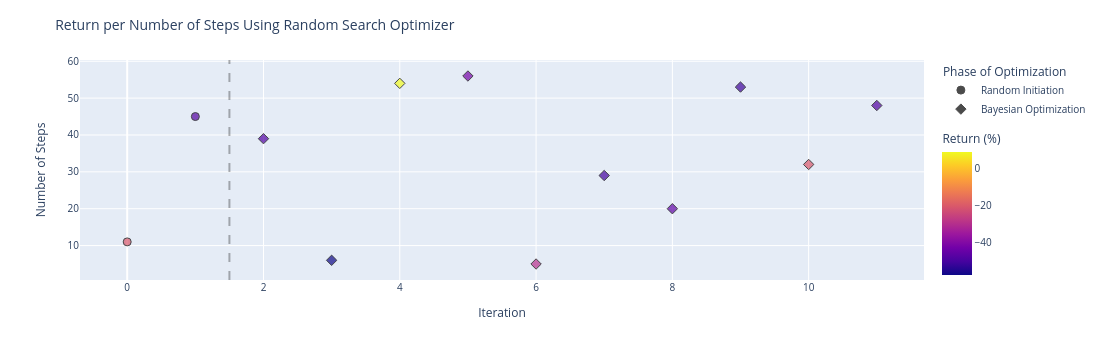

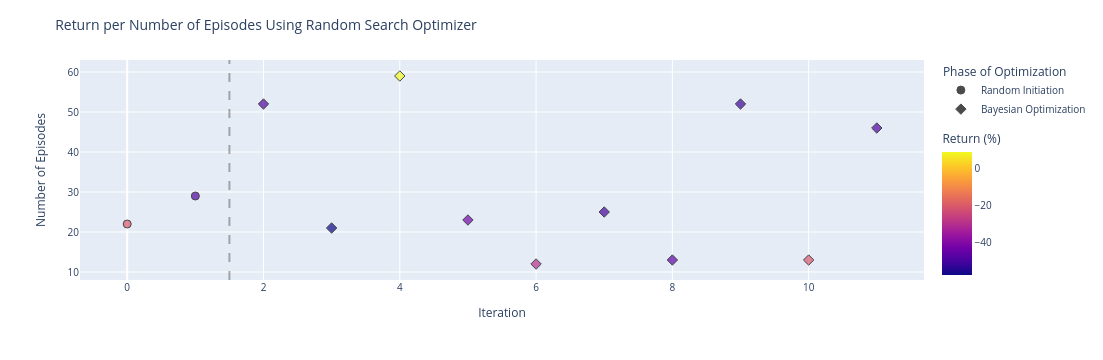

In [17]:
plot_hyperparams(params, optimizer, init_set)

In [18]:
# Imports Optimizer
from Optimizer.GPHedgeOptimizer import GP_HedgeBayesianOptimizer
set_random_seed(42)
eta=0.01

In [19]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='GP Hedge',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = GP_HedgeBayesianOptimizer(objective_func, bounds, types, name='GP Hedge', eta=eta)
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:11<00:00,  1.99it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [03:34<00:00,  7.39s/it]


Complete


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor([  0.6250, 353.5782, 391.9651,   3.2704,  19.5875])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [03:25<00:00, 10.29s/it]


Complete


 10%|████▎                                      | 1/10 [03:29<31:26, 209.56s/it]

tensor([  0.8610, 263.7543, 387.6081,  46.8135,  30.4134])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [04:18<00:00,  8.61s/it]


Complete


 20%|████████▌                                  | 2/10 [07:50<31:56, 239.51s/it]

tensor([  0.8127, 147.3375, 377.0932,  33.8055,  34.6280])
Training DeepRL ...



100%|███████████████████████████████████████████| 35/35 [04:05<00:00,  7.03s/it]


Complete


 30%|████████████▉                              | 3/10 [11:58<28:24, 243.48s/it]

tensor([  0.4443,  66.3622, 108.0673,  63.8498,  23.0026])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [02:12<00:00,  5.78s/it]


Complete


 40%|█████████████████▏                         | 4/10 [14:13<20:04, 200.70s/it]

tensor([  0.9040, 175.5517, 437.0596,  61.0542,  51.6025])
Training DeepRL ...



100%|███████████████████████████████████████████| 52/52 [06:19<00:00,  7.29s/it]


Complete


 50%|█████████████████████▌                     | 5/10 [20:34<22:09, 265.92s/it]

tensor([  0.9527, 490.3159, 390.8213,  53.1882,  49.6510])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:22<00:00,  2.18it/s]


Complete


 60%|█████████████████████████▊                 | 6/10 [20:59<12:15, 183.99s/it]

tensor([  0.8667, 467.8563, 237.7954,  47.3914,  27.3003])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [00:12<00:00,  2.17it/s]


Complete


 70%|██████████████████████████████             | 7/10 [21:14<06:25, 128.58s/it]

tensor([  0.6374,  58.2001, 211.1526,  52.5547,  25.8254])
Training DeepRL ...



100%|███████████████████████████████████████████| 26/26 [02:24<00:00,  5.55s/it]


Complete


 80%|██████████████████████████████████▍        | 8/10 [23:40<04:28, 134.29s/it]

tensor([  0.9192, 501.7805,  78.1360,  54.8739,  57.6531])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:27<00:00,  2.14it/s]


Complete


 90%|██████████████████████████████████████▋    | 9/10 [24:09<01:41, 101.40s/it]

tensor([  0.7893, 454.6008,  99.3277,  58.8733,  58.0011])
Training DeepRL ...



100%|███████████████████████████████████████████| 58/58 [00:27<00:00,  2.11it/s]


Complete


100%|██████████████████████████████████████████| 10/10 [24:39<00:00, 147.95s/it]


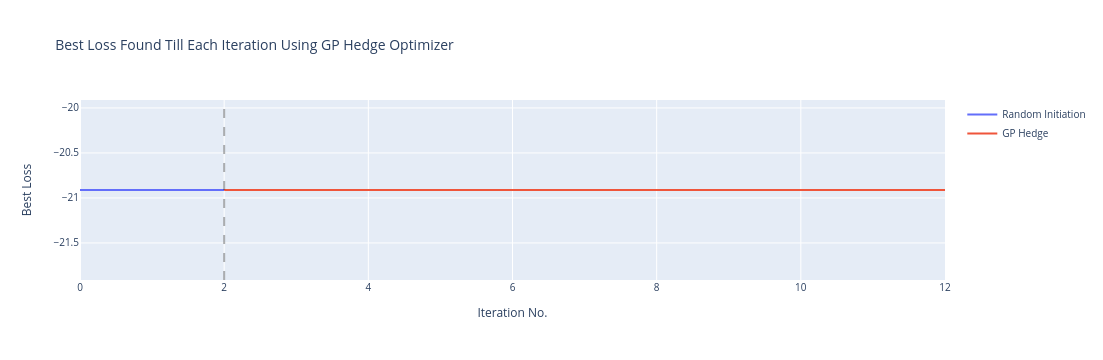

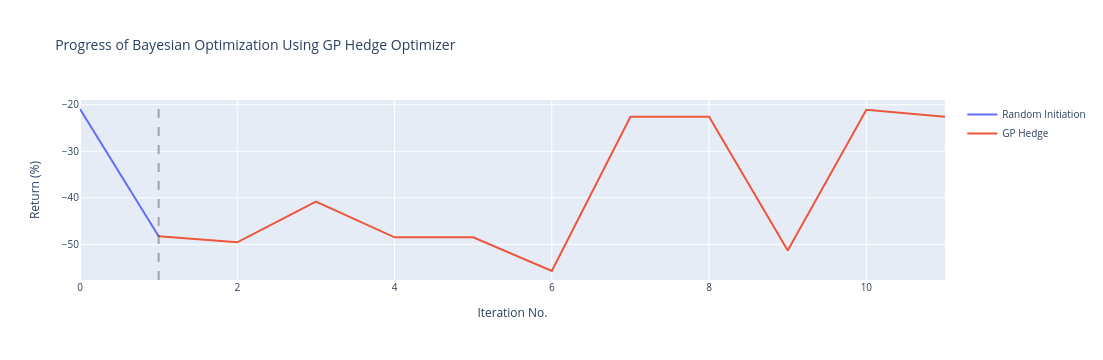

In [20]:
plot_optimization_progress(optimizer, init_set)

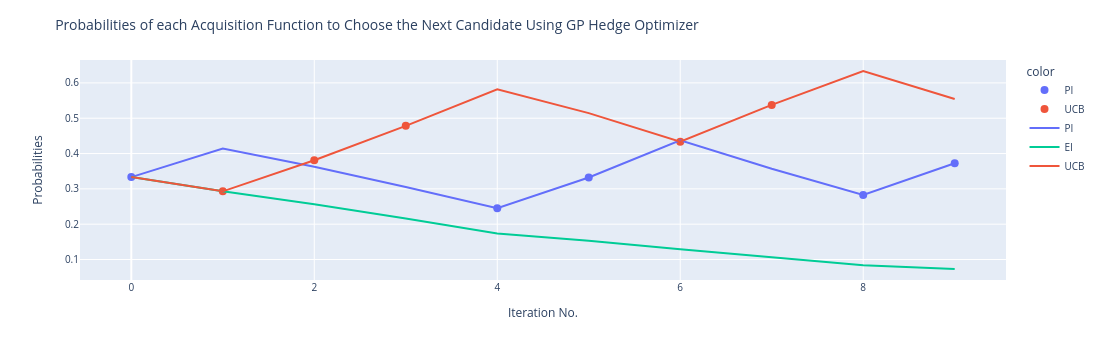

In [21]:
plot_prob_accusition(optimizer)

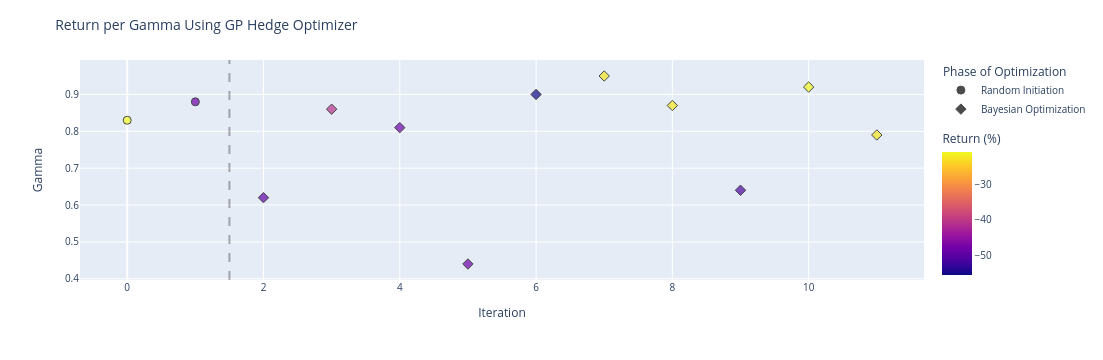

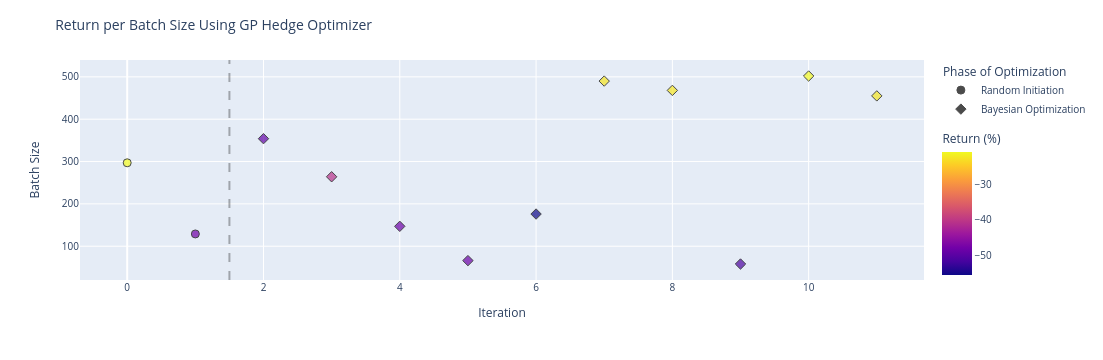

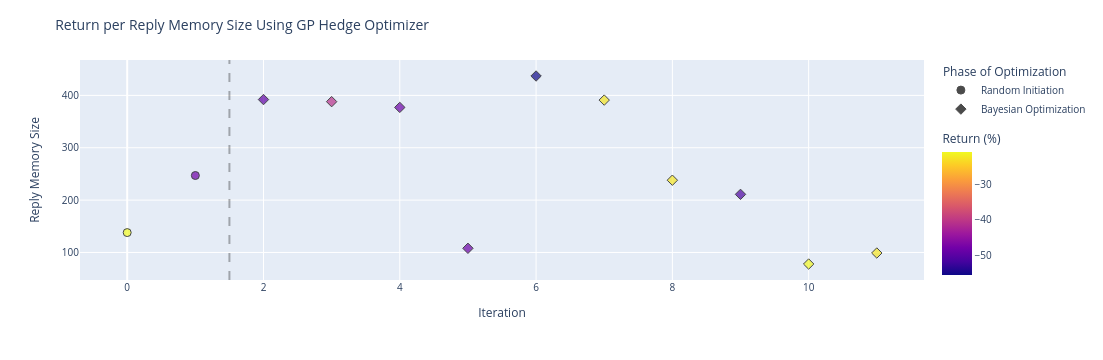

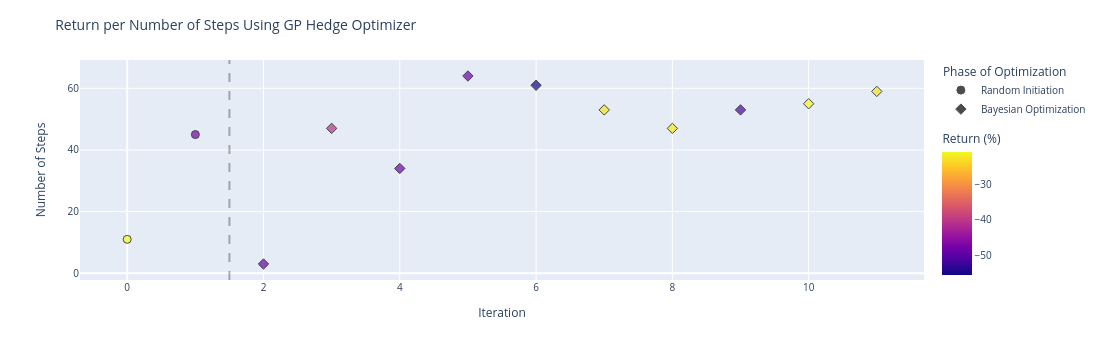

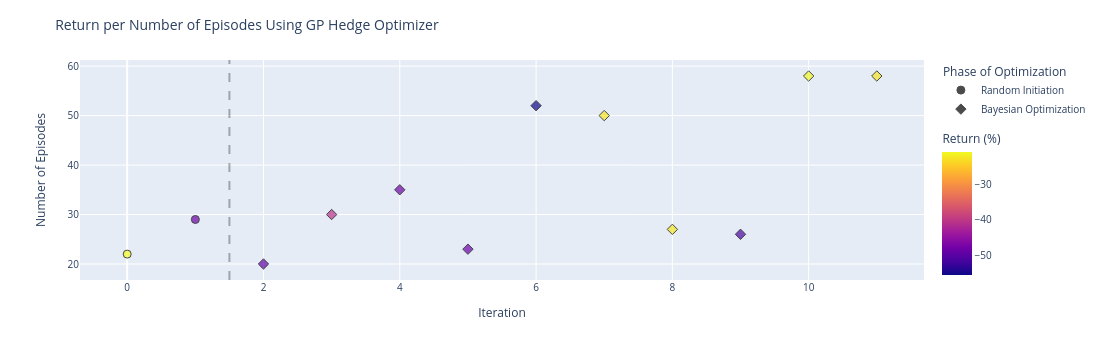

In [22]:
plot_hyperparams(params, optimizer, init_set)

In [23]:
# Imports Optimizer
from Optimizer.NoPastBayesianOptimizer import NoPastBayesianOptimizer
set_random_seed(42)
eta = 0.1
m = 0.8

In [24]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='No-Past-BO',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = NoPastBayesianOptimizer(objective_func, bounds, types, name='No-Past-BO', eta=eta, m=m)
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}_m:{m}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}_m:{m}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.12it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [03:16<00:00,  6.76s/it]


Complete


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor([  0.9572, 239.7775, 239.8351,  32.1398,  22.5002])
Training DeepRL ...



100%|███████████████████████████████████████████| 23/23 [03:13<00:00,  8.43s/it]


Complete


 10%|████▎                                      | 1/10 [03:16<29:25, 196.15s/it]

tensor([  0.9417, 141.7614,  49.9919,  42.2378,  45.2991])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [00:20<00:00,  2.17it/s]


Complete


 20%|████████▊                                   | 2/10 [03:39<12:33, 94.23s/it]

tensor([ 0.6547, 79.2705, 23.9845, 23.2892, 11.2413])
Training DeepRL ...



100%|███████████████████████████████████████████| 11/11 [00:04<00:00,  2.23it/s]


Complete


 30%|█████████████▏                              | 3/10 [03:46<06:21, 54.50s/it]

tensor([  0.7389, 223.6689, 108.7018,  12.1319,  19.5913])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.11it/s]


Complete


 40%|█████████████████▌                          | 4/10 [03:57<03:45, 37.60s/it]

tensor([  0.8277,  77.7823, 492.0705,  41.6649,  19.9667])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.91s/it]


Complete


 50%|██████████████████████                      | 5/10 [05:59<05:38, 67.69s/it]

tensor([  0.7578,  18.0203, 162.4635,  52.7991,  52.7333])
Training DeepRL ...



100%|███████████████████████████████████████████| 53/53 [04:21<00:00,  4.93s/it]


Complete


 60%|█████████████████████████▊                 | 6/10 [10:22<08:57, 134.42s/it]

tensor([  0.8165,  75.9509, 361.4384,  33.2264,  33.5309])
Training DeepRL ...



100%|███████████████████████████████████████████| 34/34 [03:20<00:00,  5.90s/it]


Complete


 70%|██████████████████████████████             | 7/10 [13:45<07:50, 156.85s/it]

tensor([  0.8411, 396.0767, 250.5915,  27.1507,  14.1496])
Training DeepRL ...



100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.24it/s]


Complete


 80%|██████████████████████████████████▍        | 8/10 [13:54<03:39, 109.71s/it]

tensor([  0.7503, 284.0608, 343.5178,  16.7078,  35.8414])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [05:23<00:00,  8.97s/it]


Complete


 90%|██████████████████████████████████████▋    | 9/10 [19:20<02:57, 177.17s/it]

tensor([  0.7920,  85.2168, 196.2760,  30.7253,  24.9760])
Training DeepRL ...



100%|███████████████████████████████████████████| 25/25 [02:30<00:00,  6.04s/it]


Complete


100%|██████████████████████████████████████████| 10/10 [21:53<00:00, 131.39s/it]


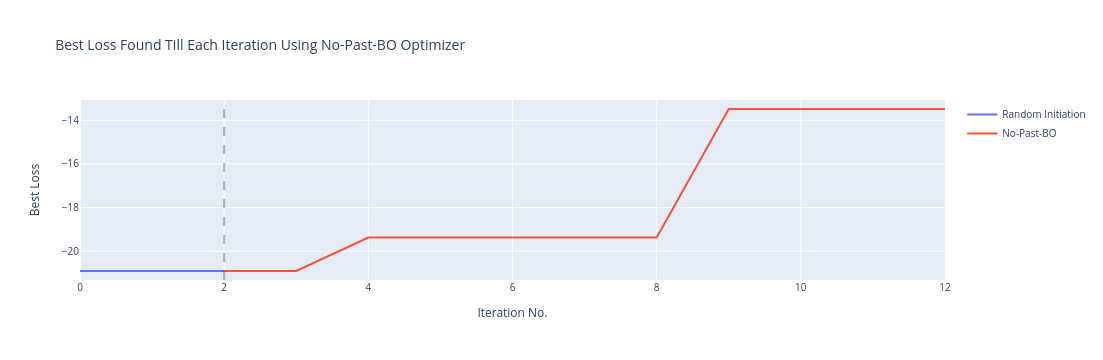

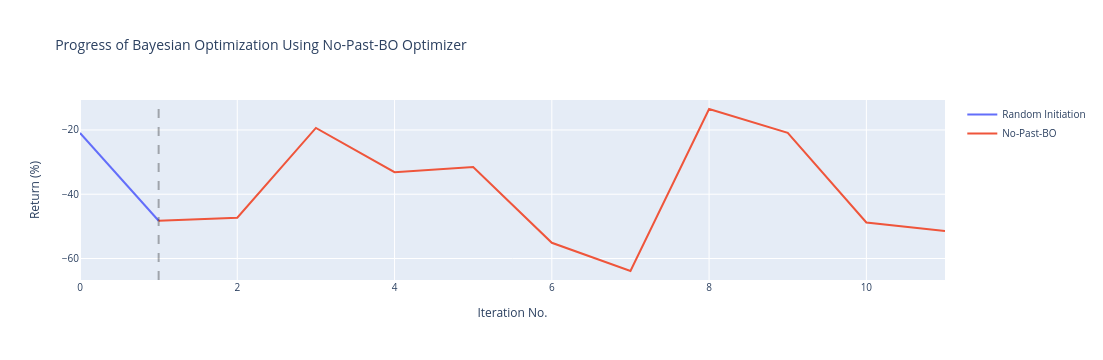

In [25]:
plot_optimization_progress(optimizer, init_set)

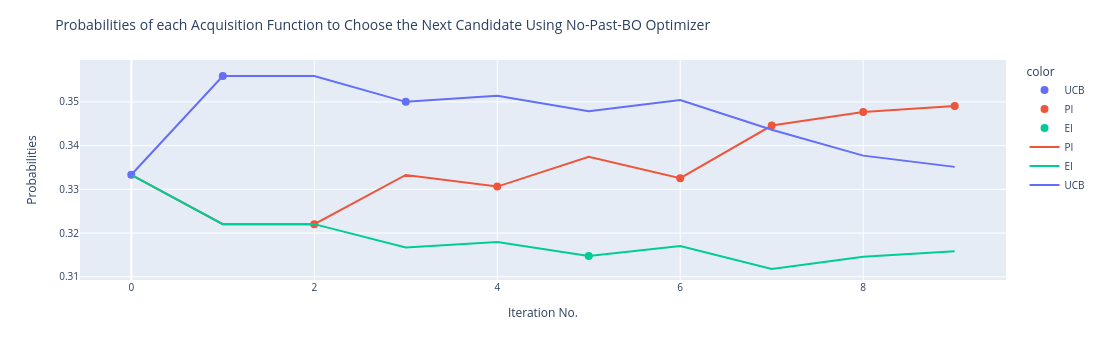

In [26]:
plot_prob_accusition(optimizer)

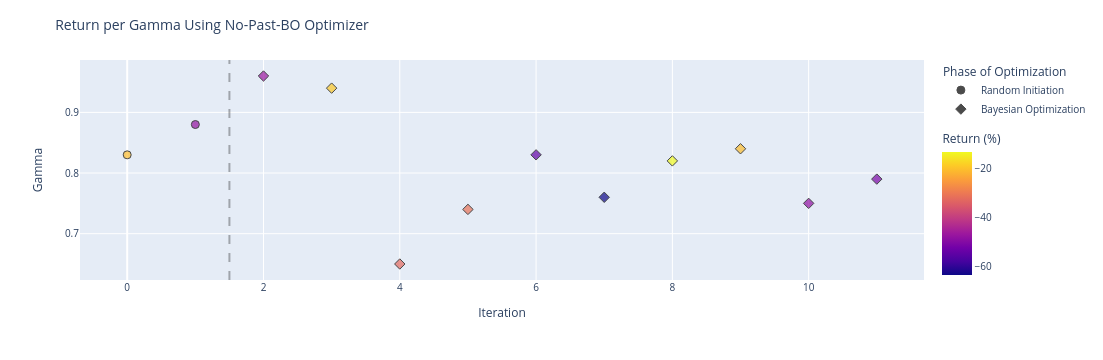

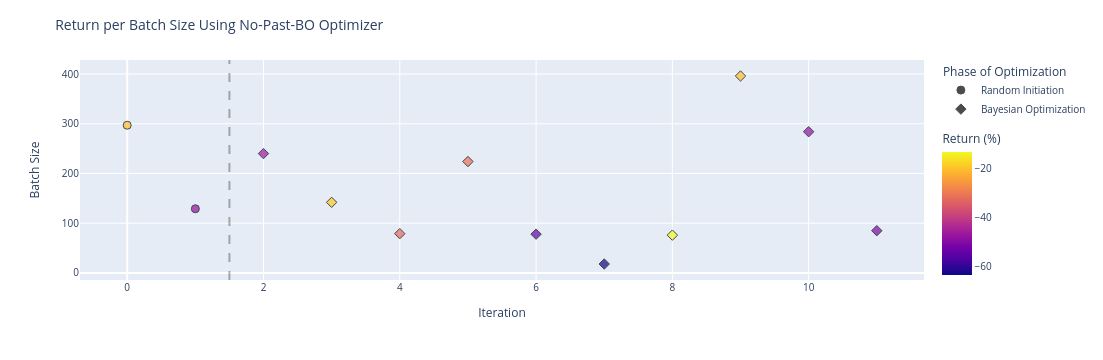

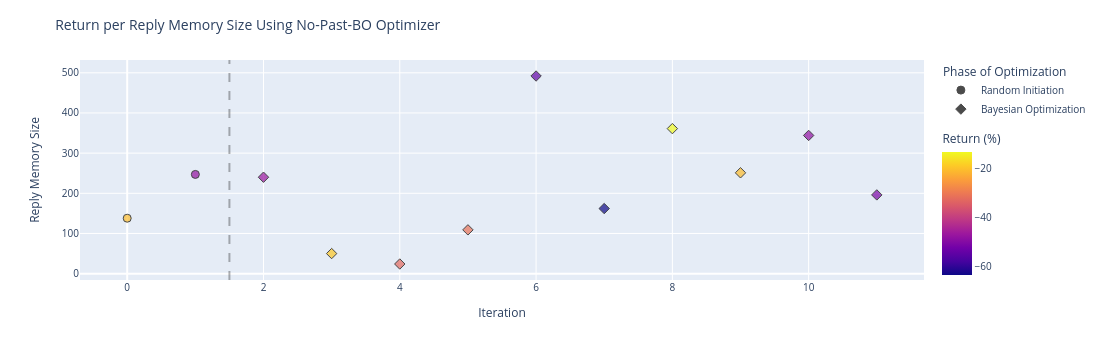

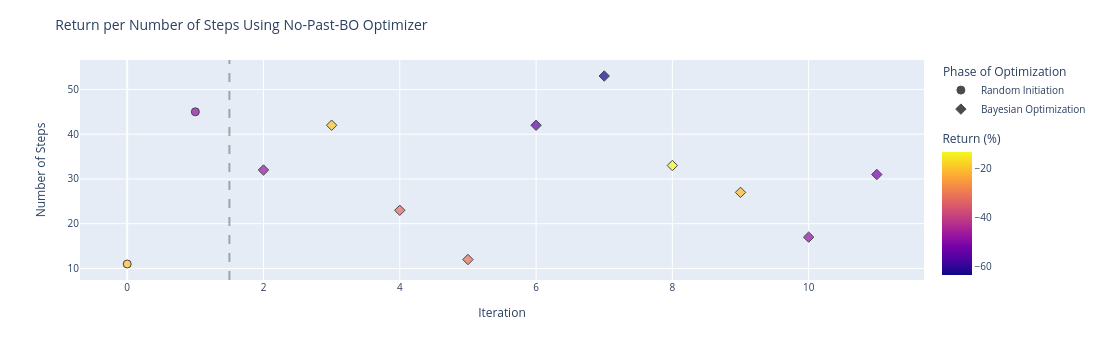

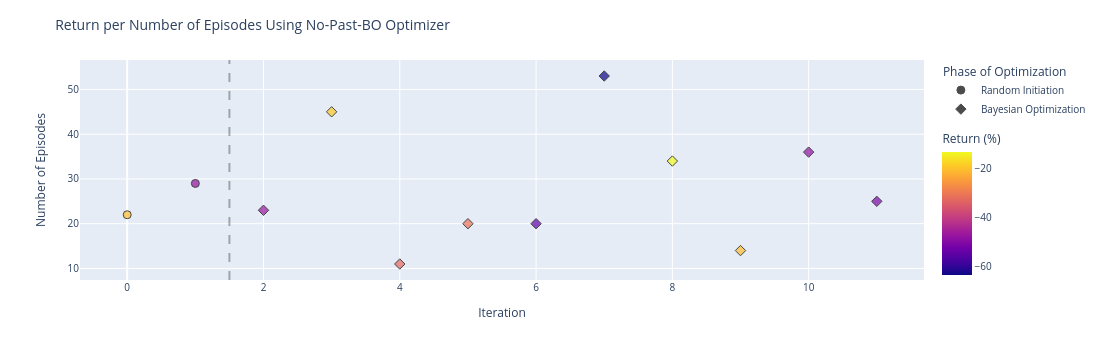

In [27]:
plot_hyperparams(params, optimizer, init_set)

In [28]:
# Imports Optimizer
from Optimizer.NoPastBayesianOptimizerVarM import NoPastBoVarM
set_random_seed(42)
eta = 1.0
m_start = 0.1
m_end = 1.0

In [29]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='No-Past-BO-VarM',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = NoPastBoVarM(objective_func, bounds, types, name='No-Past-BO-VarM', eta=eta, m_start=m_start, m_end=m_end)
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}_m:{m_start}-{m_end}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}_eta:{eta}_m:{m_start}-{m_end}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.18it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [03:13<00:00,  6.66s/it]


Complete


  0%|                                                    | 0/10 [00:00<?, ?it/s]

tensor([  0.7646, 103.0874, 209.4678,  51.4150,  15.5989])
Training DeepRL ...



100%|███████████████████████████████████████████| 16/16 [01:40<00:00,  6.31s/it]


Complete


 10%|████▎                                      | 1/10 [01:43<15:33, 103.71s/it]

tensor([4.5811e-01, 1.9197e+01, 4.6913e+02, 3.7016e+01, 4.1303e+01])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [03:23<00:00,  4.96s/it]


Complete


 20%|████████▌                                  | 2/10 [05:09<21:49, 163.66s/it]

tensor([  0.7922, 267.6503, 180.0348,  30.9463,  28.3280])
Training DeepRL ...



100%|███████████████████████████████████████████| 28/28 [00:13<00:00,  2.12it/s]


Complete


 30%|█████████████▏                              | 3/10 [05:24<11:12, 96.07s/it]

tensor([  0.9199, 279.3643, 231.7732,  42.3130,  38.4948])
Training DeepRL ...



100%|███████████████████████████████████████████| 38/38 [00:17<00:00,  2.19it/s]


Complete


 40%|█████████████████▌                          | 4/10 [05:44<06:35, 65.90s/it]

tensor([  0.7616, 207.2238,  18.3447,   7.5253,  41.0966])
Training DeepRL ...



100%|███████████████████████████████████████████| 41/41 [00:18<00:00,  2.17it/s]


Complete


 50%|██████████████████████                      | 5/10 [06:06<04:09, 49.95s/it]

tensor([  0.8384,  88.9497, 374.6040,   7.7484,  19.7551])
Training DeepRL ...



100%|███████████████████████████████████████████| 20/20 [02:02<00:00,  6.10s/it]


Complete


 60%|██████████████████████████▍                 | 6/10 [08:10<05:00, 75.20s/it]

tensor([  0.6743, 258.9258, 465.6091,  15.5890,  44.6134])
Training DeepRL ...



100%|███████████████████████████████████████████| 45/45 [06:24<00:00,  8.54s/it]


Complete


 70%|██████████████████████████████             | 7/10 [14:37<08:50, 176.98s/it]

tensor([  0.5694,  79.6788, 439.5069,  58.1621,  30.2177])
Training DeepRL ...



100%|███████████████████████████████████████████| 30/30 [02:54<00:00,  5.83s/it]


Complete


 80%|██████████████████████████████████▍        | 8/10 [17:34<05:54, 177.05s/it]

tensor([  0.6896, 502.2657, 489.4556,  29.1898,  17.6400])
Training DeepRL ...



100%|███████████████████████████████████████████| 18/18 [00:08<00:00,  2.22it/s]


Complete


 90%|██████████████████████████████████████▋    | 9/10 [17:44<02:04, 124.94s/it]

tensor([  0.4593,  99.4641, 273.1907,  56.9117,  26.8621])
Training DeepRL ...



100%|███████████████████████████████████████████| 27/27 [02:45<00:00,  6.13s/it]


Complete


100%|██████████████████████████████████████████| 10/10 [20:32<00:00, 123.25s/it]


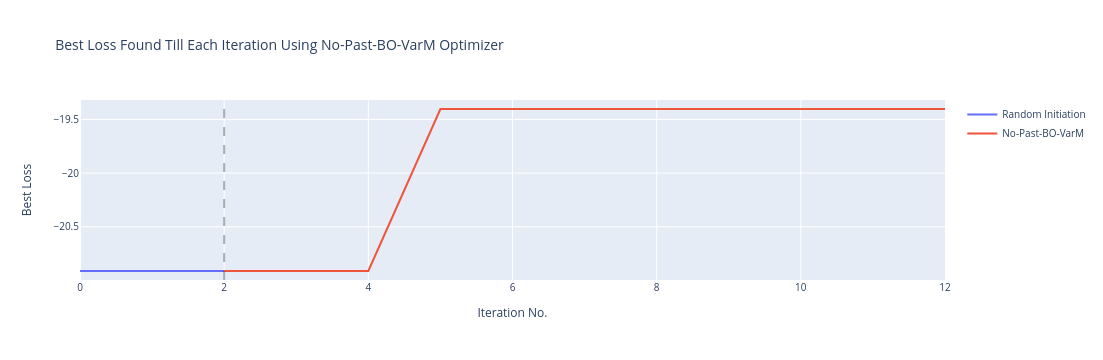

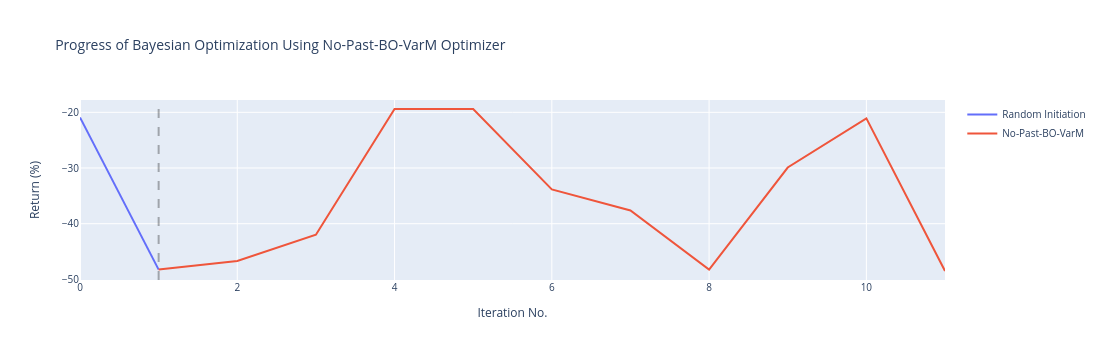

In [30]:
plot_optimization_progress(optimizer, init_set)

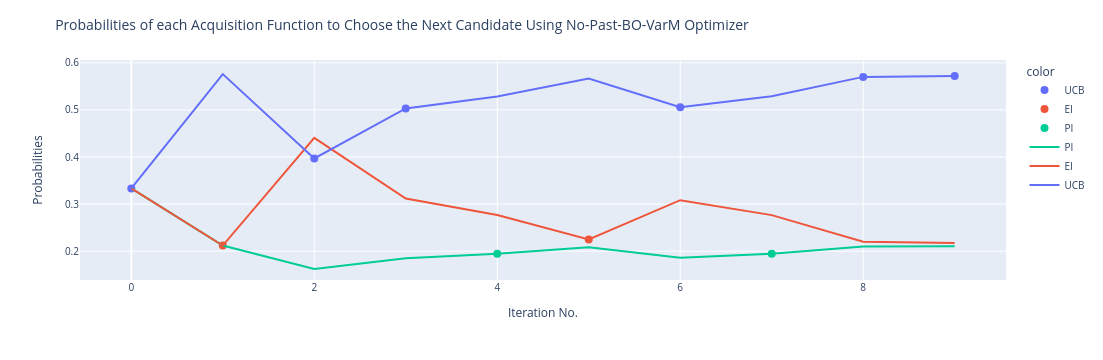

In [31]:
plot_prob_accusition(optimizer)

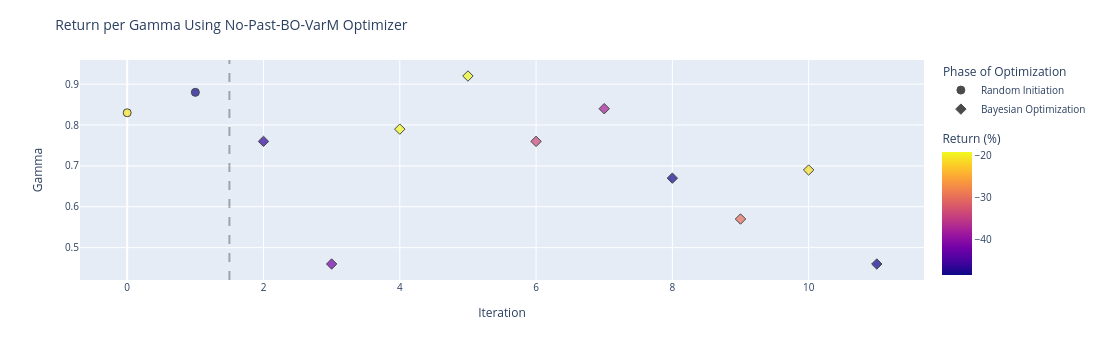

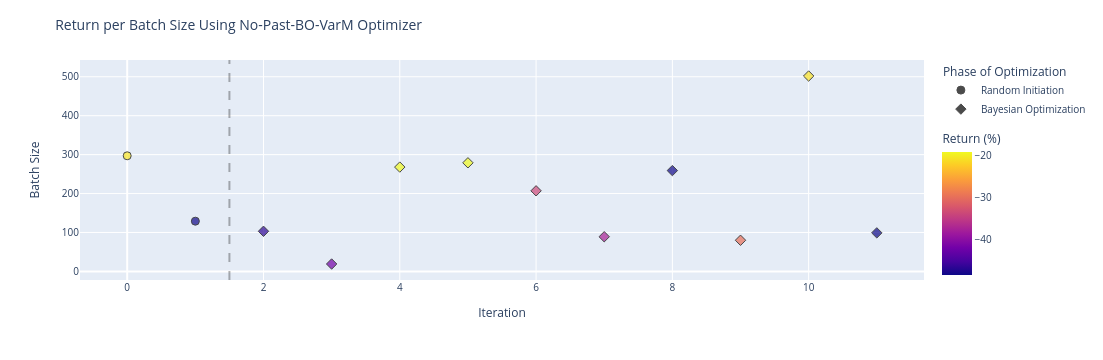

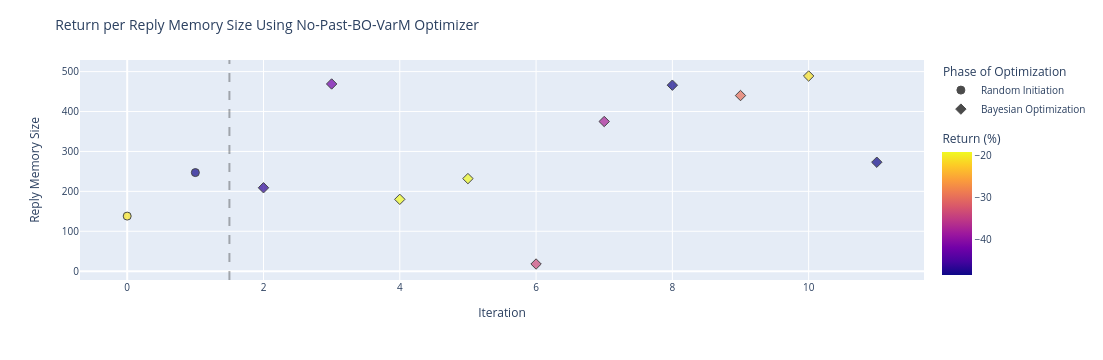

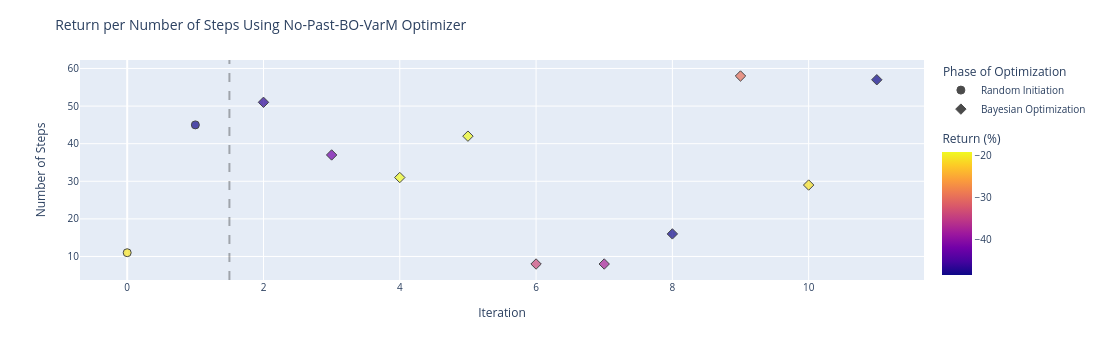

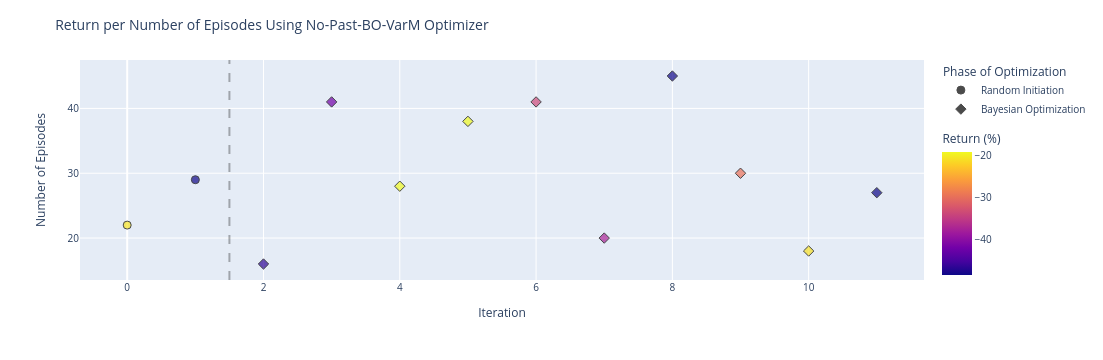

In [32]:
plot_hyperparams(params, optimizer, init_set)

In [33]:
# Imports Optimizer
from Optimizer.SETUPOptimaizer import SETUPBayesianOptimizer
set_random_seed(42)

In [34]:
run = SensitivityRun(
    dataset_name,
    gamma_default,
    batch_size_default,
    replay_memory_size_default,
    feature_size,
    target_update,
    n_episodes,
    n_step,
    window_size,
    device,
    evaluation_parameter='SETUP-BO',
    transaction_cost=0)

for model_name  in models:

    run.model_in_question = model_name

    def objective_func(params):
        print(params)
        run.gamma = round(params[0].item(), 2)
        run.batch_size = int(round(params[1].item()))
        run.replay_memory_size = int(round(params[2].item()))
        run.n_step = int(round(params[3].item()))
        run.n_episodes = int(round(params[4].item()))
        set_random_seed(42)
        run.reset()
        run.train()
        set_random_seed()
        run.evaluate_sensitivity()
        eval = torch.tensor([run.average_return()])
        X = torch.tensor([
            round(params[0].item(), 2),
            int(round(params[1].item())),
            int(round(params[2].item())),
            int(round(params[3].item())),
            int(round(params[4].item()))
            ])
        return eval, X

    optimizer = SETUPBayesianOptimizer(objective_func, bounds, types, name='SETUP BO')
    run.evaluation_parameter = optimizer.optimizer_name
    optimizer.optimize(n_steps=iter, n_init_points=init_set)

    run.save_experiment()

    path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/{run.model_in_question}/')
    if not os.path.exists(path):
        os.makedirs(path)
    save_pkl(os.path.join(path, 'optimizer.pkl'), optimizer)

    optimizer.save_plots(path)

path = os.path.join(os.getcwd(), f'run/{optimizer.optimizer_name}/')
if not os.path.exists(path):
    os.makedirs(path)
save_pkl(os.path.join(path, 'run.pkl'), run)

tensor([  0.8341, 297.0000, 138.0000,  11.0000,  22.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 22/22 [00:10<00:00,  2.09it/s]


Complete
tensor([  0.8830, 129.0000, 247.0000,  45.0000,  29.0000], dtype=torch.float64)
Training DeepRL ...


100%|███████████████████████████████████████████| 29/29 [03:18<00:00,  6.84s/it]


Complete


  0%|                                                    | 0/10 [00:00<?, ?it/s]

3.0 {'PI': 0.3333333333333333, 'EI': 0.3333333333333333, 'UCB': 0.3333333333333333}
tensor([ 0.7090, 63.7656, 18.0794, 49.8924, 28.6664])
Training DeepRL ...



100%|███████████████████████████████████████████| 29/29 [00:19<00:00,  1.51it/s]


Complete


 10%|████▍                                       | 1/10 [00:22<03:18, 22.05s/it]

1.0 {'PI': 1.917819591624889e-193, 'EI': 1.0, 'UCB': 1.917819591624889e-193}
tensor([  0.9841, 327.2943, 410.9579,  55.7880,  59.1309])
Training DeepRL ...



100%|███████████████████████████████████████████| 59/59 [12:42<00:00, 12.93s/it]


Complete


 20%|████████▏                                | 2/10 [13:07<1:01:14, 459.28s/it]

1.0 {'PI': 6.08332518733552e-203, 'EI': 1.0, 'UCB': 6.08332518733552e-203}
tensor([  0.4255, 404.8719, 363.1980,  43.9288,  43.4150])
Training DeepRL ...



100%|███████████████████████████████████████████| 43/43 [00:22<00:00,  1.90it/s]


Complete


 30%|████████████▉                              | 3/10 [13:32<30:28, 261.14s/it]

1.0 {'PI': 2.3827561652443968e-240, 'EI': 1.0, 'UCB': 2.3827561652443968e-240}
tensor([  0.9500, 208.3230, 491.4308,  60.1822,  49.3737])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [06:20<00:00,  7.77s/it]


Complete


 40%|█████████████████▏                         | 4/10 [19:55<30:55, 309.30s/it]

1.0 {'PI': 1.5206549928276295e-226, 'EI': 1.0, 'UCB': 1.5206549928276295e-226}
tensor([ 0.6929, 10.0143, 47.4882, 20.7158, 54.4964])
Training DeepRL ...



100%|███████████████████████████████████████████| 54/54 [04:24<00:00,  4.90s/it]


Complete


 50%|█████████████████████▌                     | 5/10 [24:23<24:31, 294.23s/it]

1.0 {'PI': 3.212913559005642e-193, 'EI': 1.0, 'UCB': 3.212913559005642e-193}
tensor([  0.9761, 508.5192, 162.7443,  55.3326,  40.1873])
Training DeepRL ...



100%|███████████████████████████████████████████| 40/40 [00:21<00:00,  1.89it/s]


Complete


 60%|█████████████████████████▊                 | 6/10 [24:46<13:28, 202.17s/it]

1.0 {'PI': 6.566042855898503e-202, 'EI': 1.0, 'UCB': 6.566042855898503e-202}
tensor([  0.7593, 419.3035, 273.1949,  26.2386,  49.4365])
Training DeepRL ...



100%|███████████████████████████████████████████| 49/49 [00:25<00:00,  1.90it/s]


Complete


 70%|██████████████████████████████             | 7/10 [25:14<07:15, 145.23s/it]

1.0 {'PI': 1.199846002759507e-196, 'EI': 1.0, 'UCB': 1.199846002759507e-196}
tensor([  0.6527, 125.4371, 280.1592,  13.2582,  57.2350])
Training DeepRL ...



100%|███████████████████████████████████████████| 57/57 [06:21<00:00,  6.70s/it]


Complete


 80%|██████████████████████████████████▍        | 8/10 [31:39<07:22, 221.33s/it]

1.0 {'PI': 2.6311542457549557e-223, 'EI': 1.0, 'UCB': 2.6311542457549557e-223}
tensor([  0.7617, 397.3990, 188.7529,  53.7743,  49.9965])
Training DeepRL ...



100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.88it/s]


Complete


 90%|██████████████████████████████████████▋    | 9/10 [32:08<02:41, 161.19s/it]

1.0 {'PI': 1.5708924114837145e-230, 'EI': 1.0, 'UCB': 1.5708924114837145e-230}
tensor([  0.9285,  74.6108, 353.8057,  24.7224,  36.3252])
Training DeepRL ...



100%|███████████████████████████████████████████| 36/36 [03:34<00:00,  5.97s/it]


Complete


100%|██████████████████████████████████████████| 10/10 [35:45<00:00, 214.50s/it]


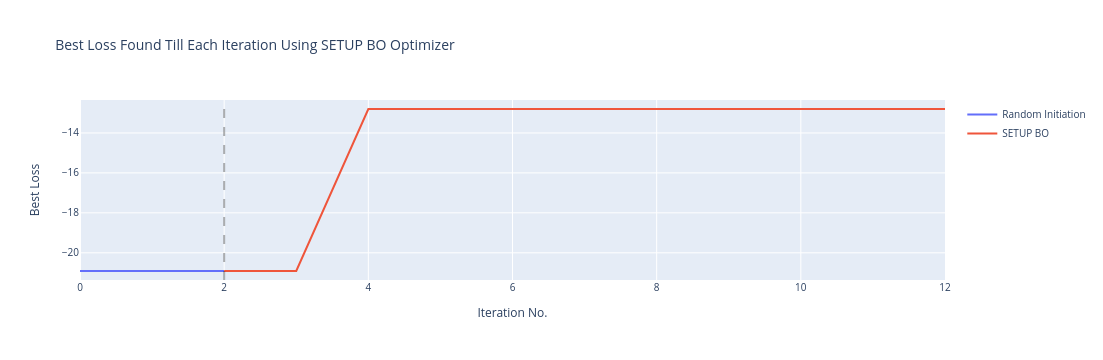

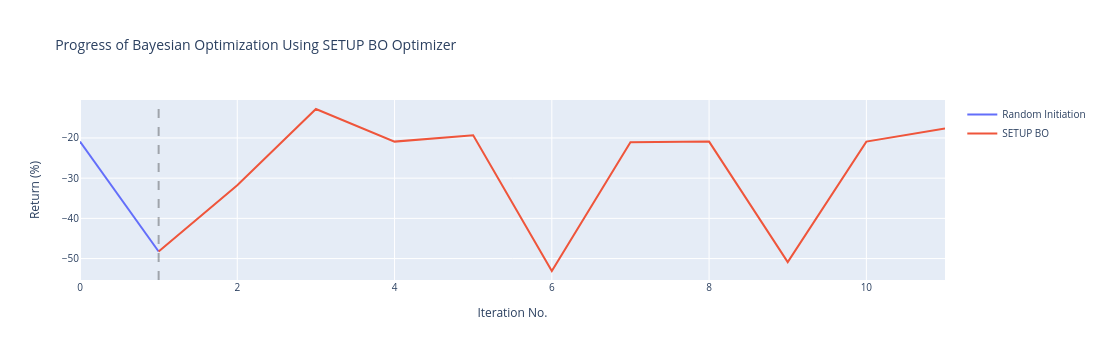

In [35]:
plot_optimization_progress(optimizer, init_set)

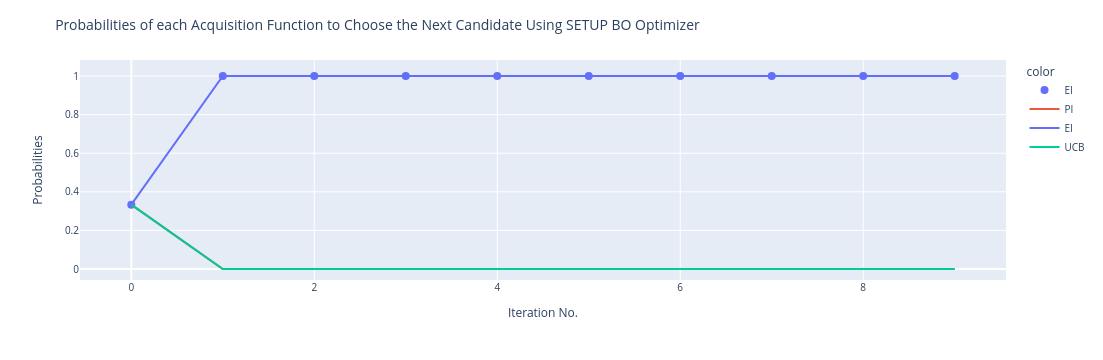

In [36]:
plot_prob_accusition(optimizer)

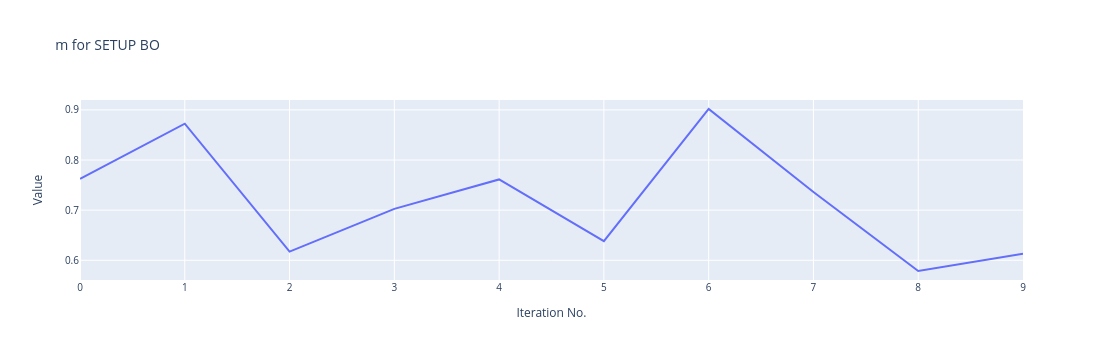

In [37]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(optimizer.m_history)), y=optimizer.m_history, mode='lines', name='m'))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Value",
    title=f"m for {optimizer.optimizer_name}",
    font=dict(size=10),
)

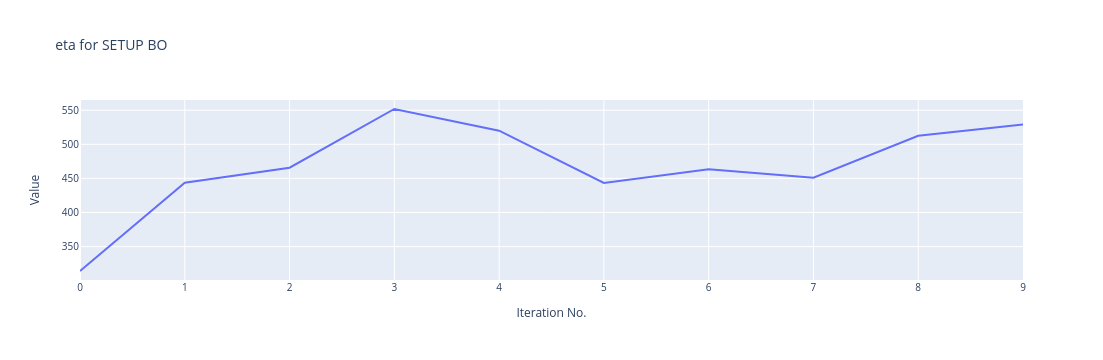

In [38]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(optimizer.eta_history)), y=optimizer.eta_history, mode='lines', name='eta'))

fig.update_layout(
    xaxis_title="Iteration No.",
    yaxis_title="Value",
    title=f"eta for {optimizer.optimizer_name}",
    font=dict(size=10),
)

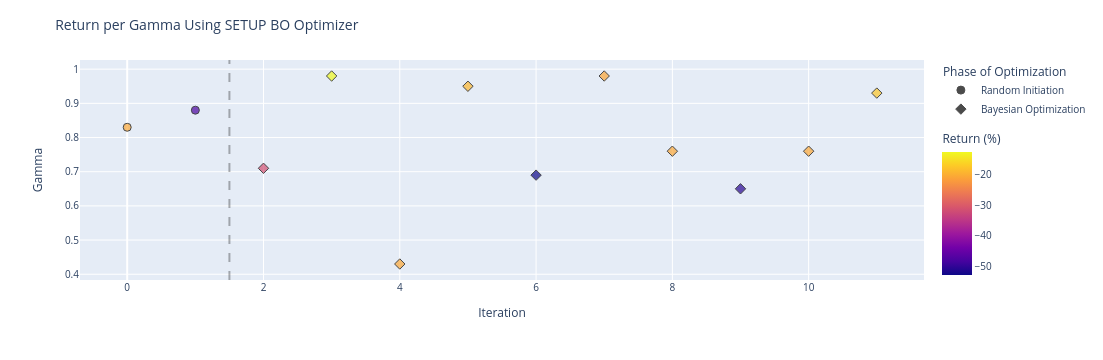

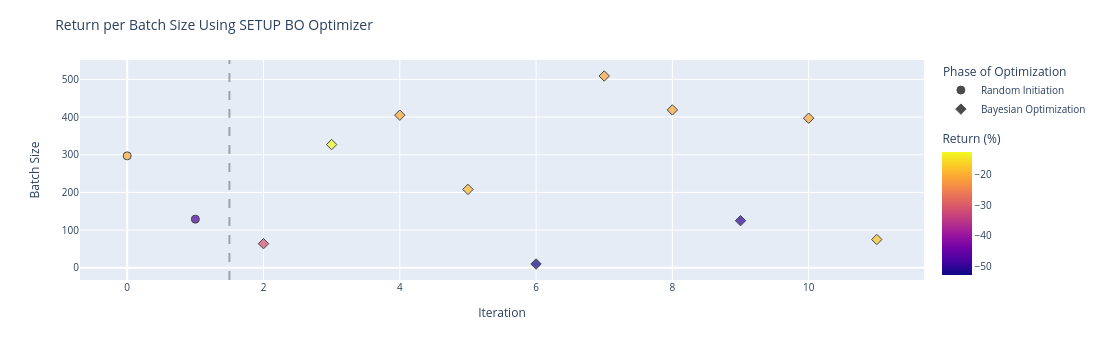

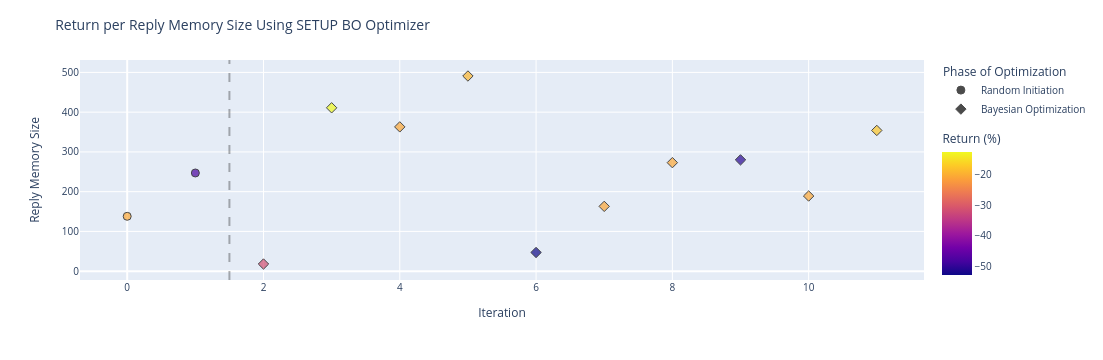

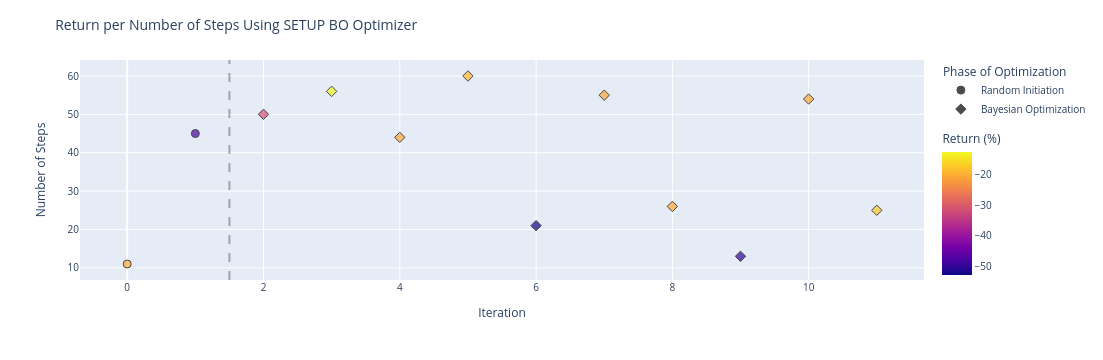

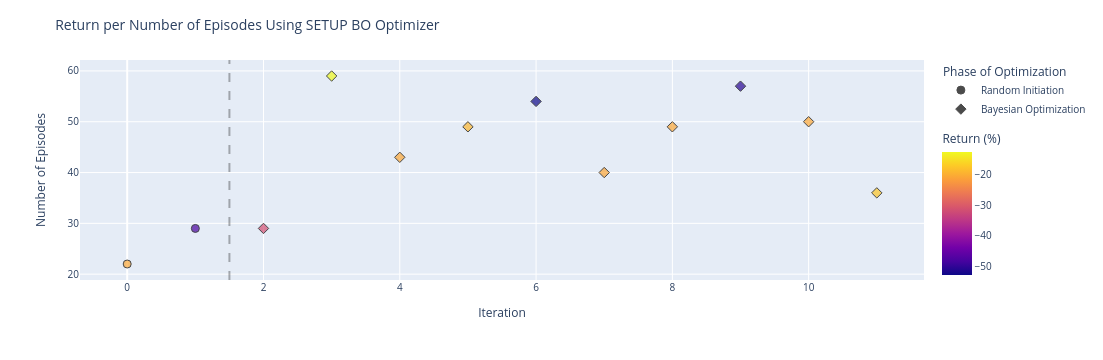

In [39]:
plot_hyperparams(params, optimizer, init_set)